# Sample diverse nucleoside structures using implicit solvent MD and torsion scan

- Cluster multiple implicit MD using pseudo sugar parameters  
- Run torsion scan against chi dihedral angle with RDKit

In [1]:
import os, sys, math
import numpy as np
import glob
import copy
import mdtraj
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import seaborn as sns
import barnaba as bb

In [2]:
# plot settings
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.precision = 1
pd.options.display.float_format = '{:.1f}'.format

params = {'legend.fontsize': 40, 
          'font.size': 40, 
          'axes.labelsize': 48,
          'axes.titlesize': 48,
          'xtick.labelsize': 40,
          'ytick.labelsize': 40,
          'savefig.dpi': 600, 
          'figure.figsize': [32, 8],
          'xtick.major.size': 10,
          'xtick.minor.size': 7,
          'ytick.major.size': 10,
          'ytick.minor.size': 7}

plt.rcParams.update(params)

In [3]:
def radian_to_degree(a):    
    a[np.where(a<0.0)] += 2.*np.pi
    a *= 180.0/np.pi
    return a

In [4]:
def plot_backbone_chi(angle):
    # histogram
    angle = radian_to_degree(angle)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.hist(angle, bins=60)
    ax.set_xlabel("chi angle")
    ax.set_ylabel("count")
    plt.show()
    plt.close()
            
    # trajectory
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(angle)
    ax.set_xlabel("frame")
    ax.set_ylabel("chi angle")
    ax.set_ylim(0,360)
    plt.show()
    plt.close

In [5]:
def plot_sugar_pucker(pucker):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1,polar=True)
    ax.scatter(pucker[0], pucker[1], s=10)

    p3 = np.pi/5
    ax.text(0.5*p3, 1.6, "C3'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(1.3*p3, 1.5, "C4'-exo",  ha='center', fontsize=16)
    ax.text(2.5*p3, 1.5, "O4'-endo", ha='center', fontsize=16)
    ax.text(3.7*p3, 1.5, "C1'-exo",  ha='center', fontsize=16)
    ax.text(4.5*p3, 1.6, "C2'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(5.5*p3, 1.5, "C3'-exo",  ha='center', fontsize=16)
    ax.text(6.5*p3, 1.5, "C4'-endo", ha='center', fontsize=16)
    ax.text(7.5*p3, 1.6, "O4'-exo",  ha='center', fontsize=16)
    ax.text(8.5*p3, 1.5, "C1'-endo", ha='center', fontsize=16)
    ax.text(9.5*p3, 1.5, "C2'-exo",  ha='center', fontsize=16)

    xt = np.arange(0, 2*np.pi, p3)
    ax.set_xticks(xt)
    ax.set_yticks([])
    ax.set_ylim(0, 1.2)
    ax.tick_params(axis='both', labelsize=12)
    plt.tight_layout()

    plt.show()
    #plt.savefig("pucker.png")    
    plt.close()

In [6]:
def cluster(feat, n_clusters):
    from sklearn.cluster import KMeans
    from scipy.spatial.distance import euclidean

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(feat)

    # Loop over all clusters and find index of closest point to the cluster center.
    frame_idx = []
    for idx in range(kmeans.n_clusters):
        # get all points assigned to each cluster
        cluster_feat = feat[kmeans.labels_ == idx]

        # get all indices of points assigned to this cluster
        cluster_idx = np.where(kmeans.labels_ == idx)[0]

        # get cluster center
        cluster_center = kmeans.cluster_centers_[idx]
        
        # find closest feature to cluster center and return frame index
        min_idx = np.argmin([euclidean(feat[_idx], cluster_center) for _idx in cluster_idx])
        frame_idx.append(cluster_idx[min_idx])

        #print('cluster center ', cluster_center)
        #print('closest point to cluster center: ', cluster_feat[min_idx])
        #print('closest index of point to cluster center: ', cluster_idx[min_idx])
        
    return frame_idx

In [7]:
def run(files, n_clusters):
    name = files[0].split('/')[2].split('.')[0]
    traj = mdtraj.load(files, top=f'../md/crd/{name}.pdb')

    # backbone chi
    chi, _ = bb.backbone_angles_traj(traj, angles=['chi'])
    chi = chi.reshape(chi.shape[0], 1)
    angle = copy.deepcopy(chi)
    plot_backbone_chi(angle)

    # sugar pucker
    pucker, _ = bb.pucker_rao_traj(traj)
    pucker = pucker.reshape(pucker.shape[0], pucker.shape[2]).T
    plot_sugar_pucker(pucker)

    # cluster
    #feat = np.concatenate((chi, pucker.T), axis=1)
    feat = pucker.T
    frame_idx = cluster(feat, n_clusters)

    # save
    traj[frame_idx].save_netcdf(f'traj_cls_{name}.nc')

    # check cluster sample
    angle = copy.deepcopy(chi)
    plot_backbone_chi(angle[frame_idx])
    plot_sugar_pucker(pucker[:,frame_idx])

## 1. Cluster trajectory

Perform Kmeans clustering using sugar pucker pseudoangle information (phase and amplitude) to get diverse sugar pucker structures.

In [8]:
n_clusters = 100

#### adenosine

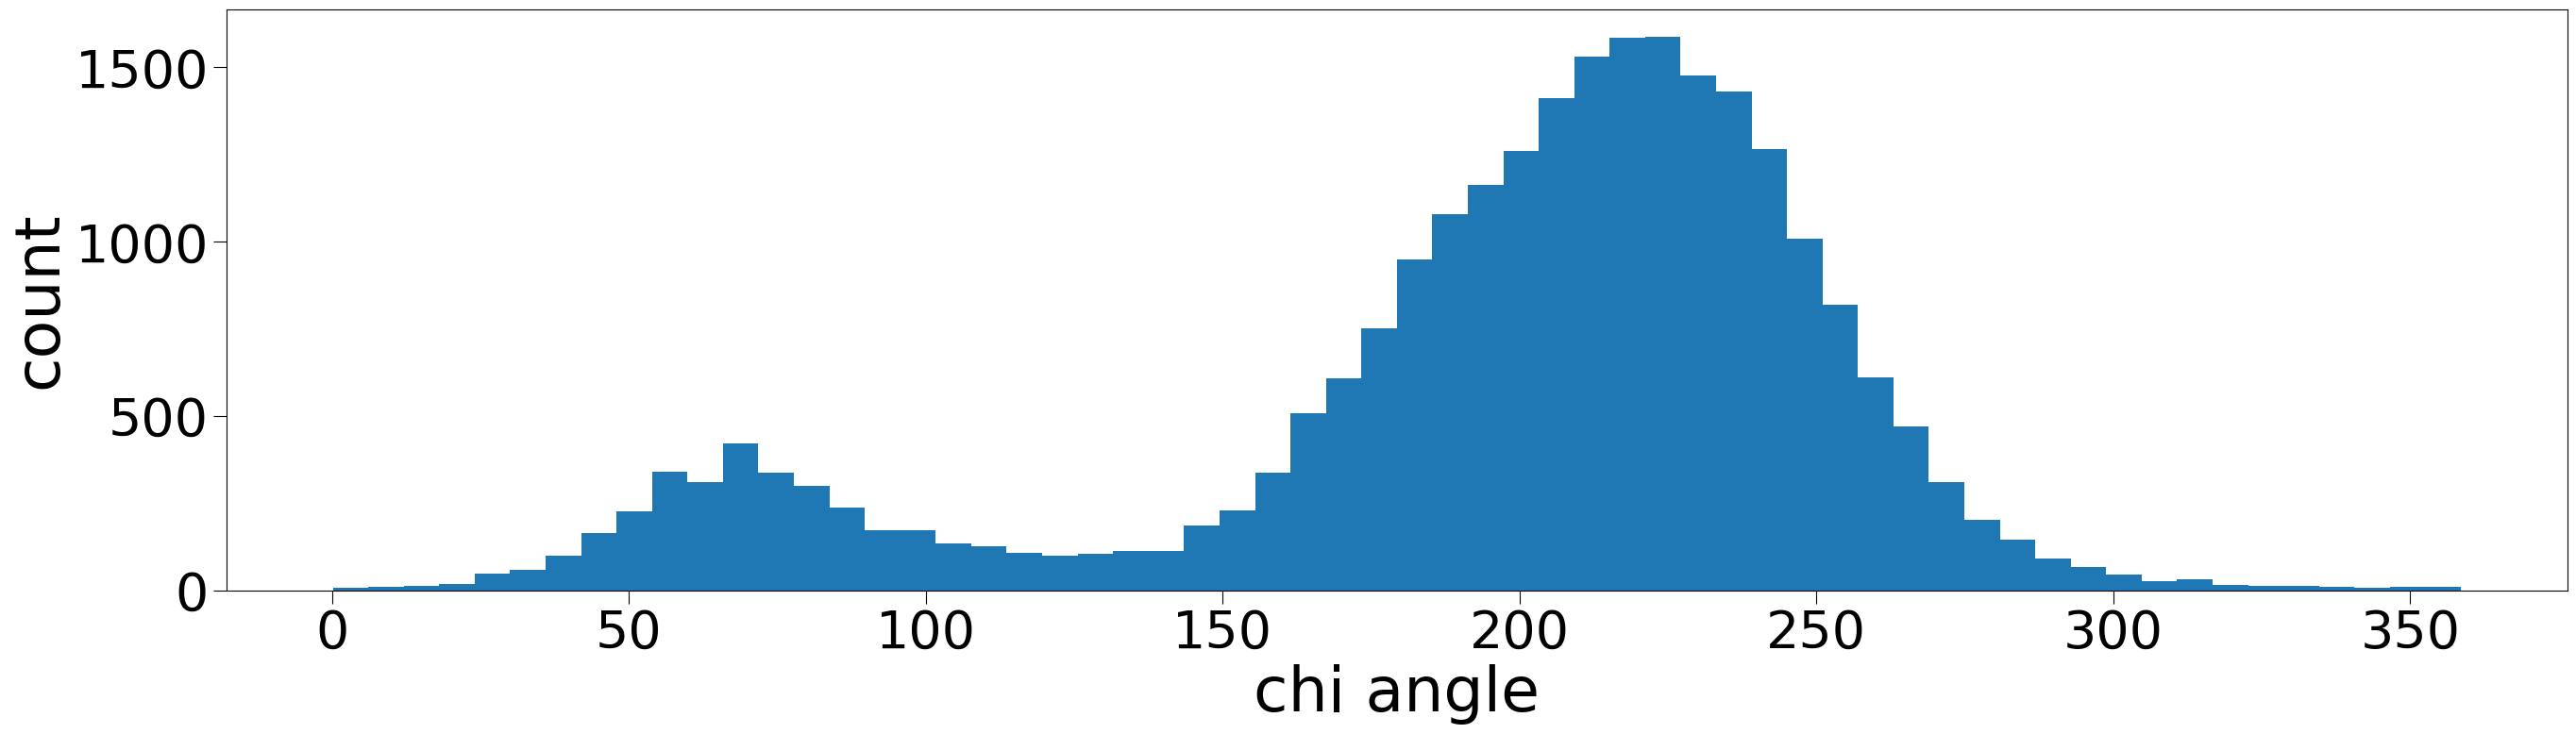

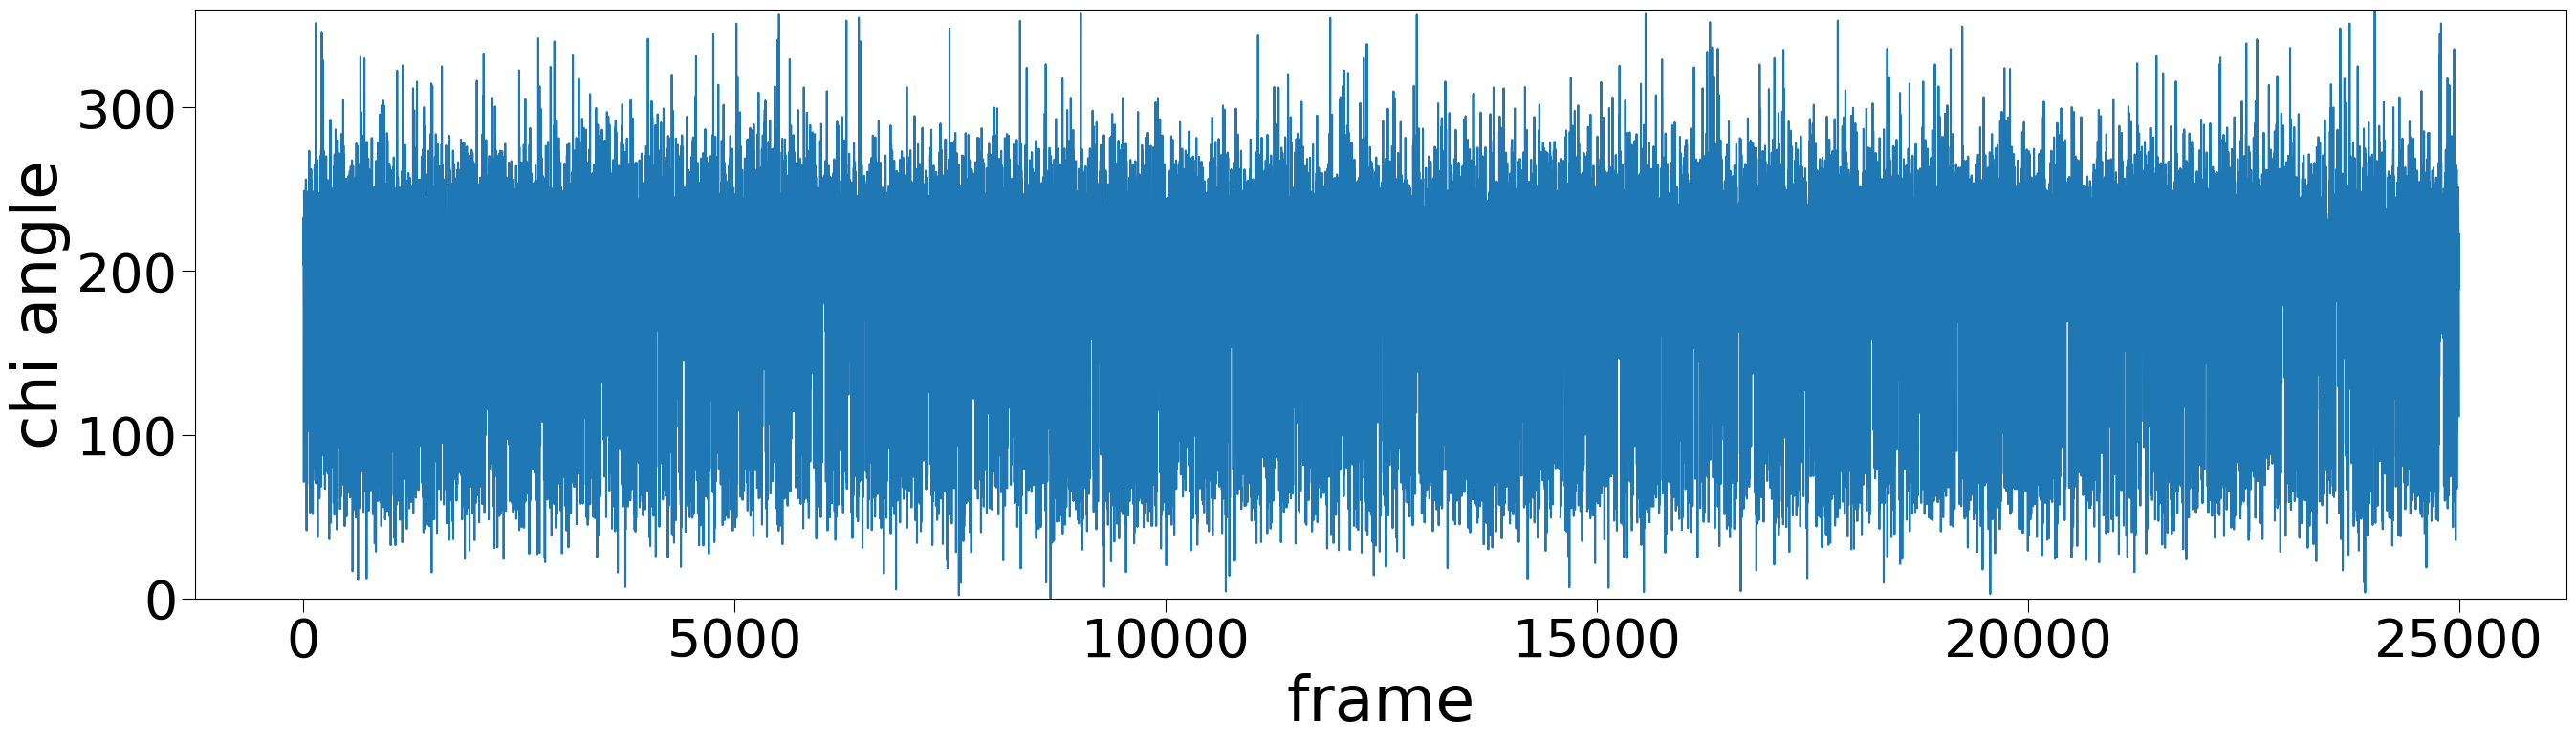

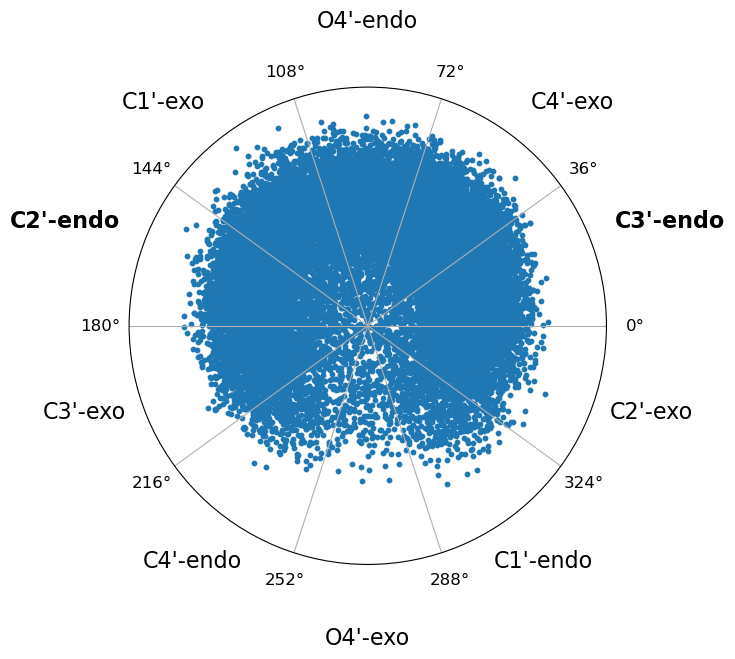

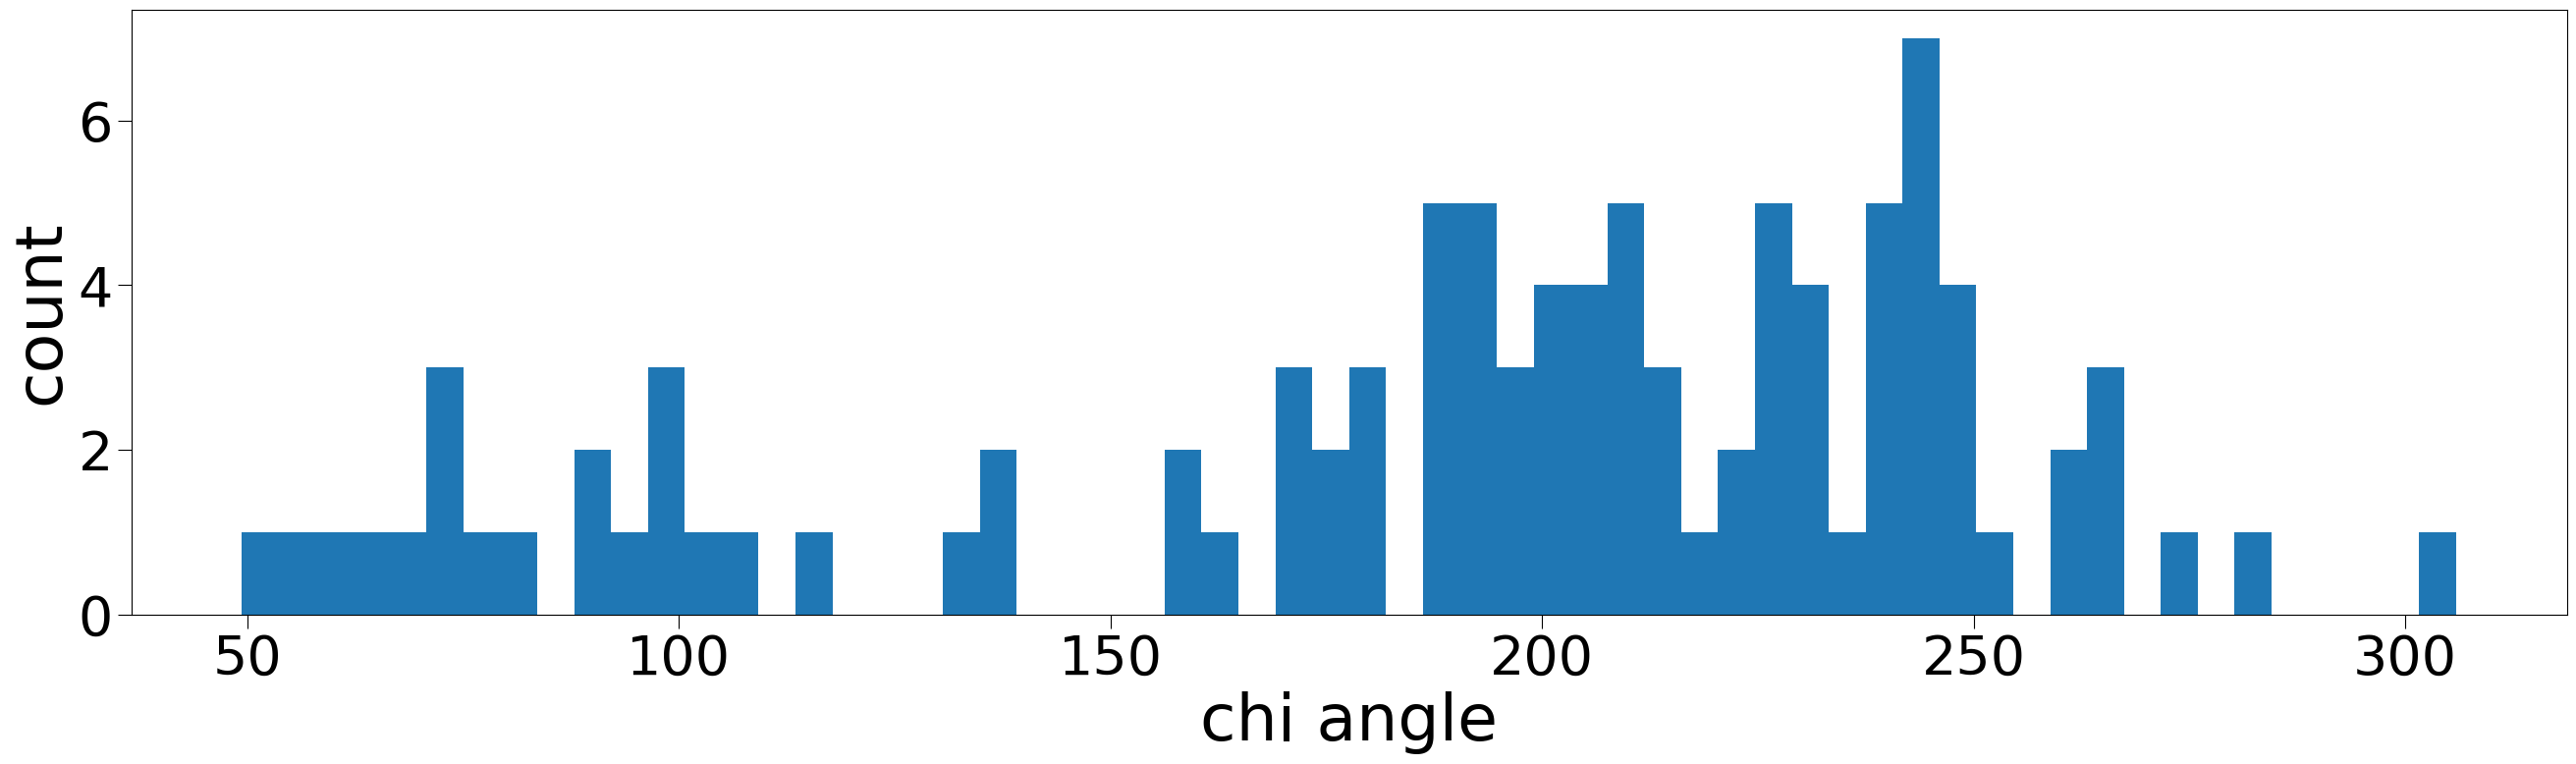

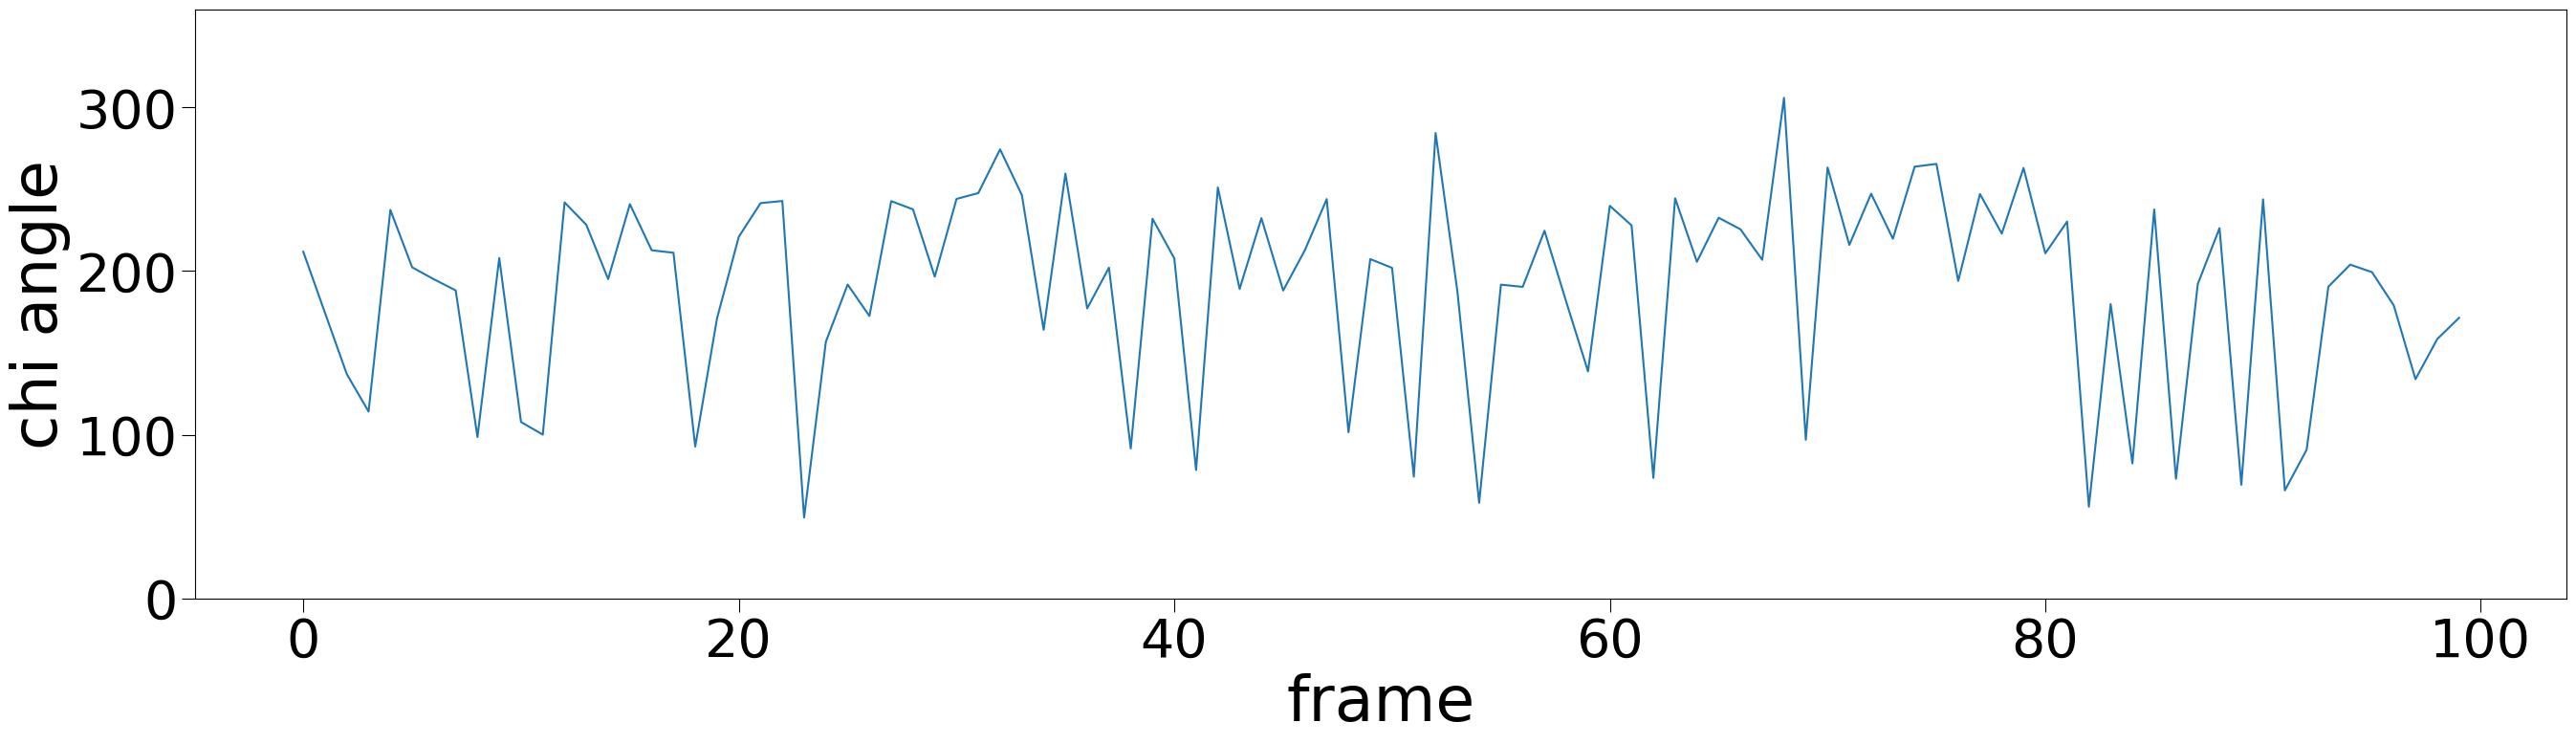

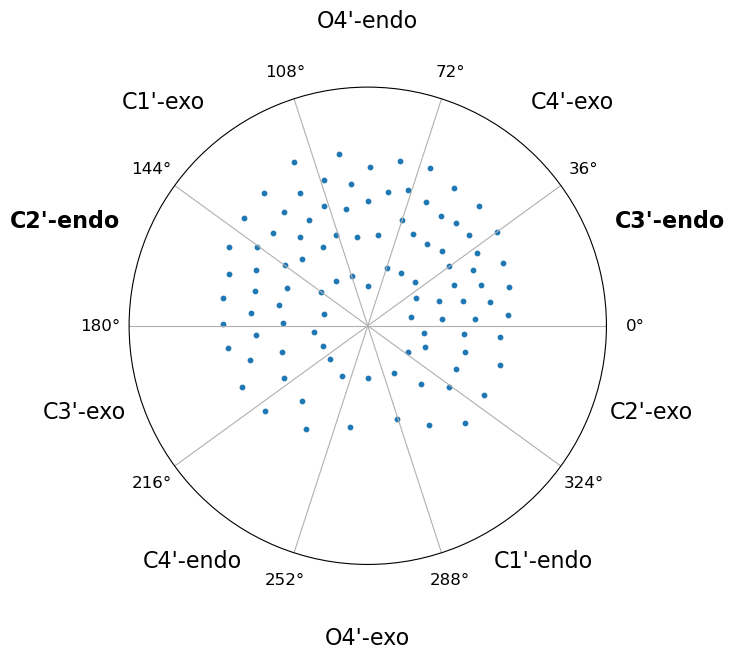

In [9]:
files = glob.glob("../md/a*/traj.nc")
run(files, n_clusters)

#### cytidine

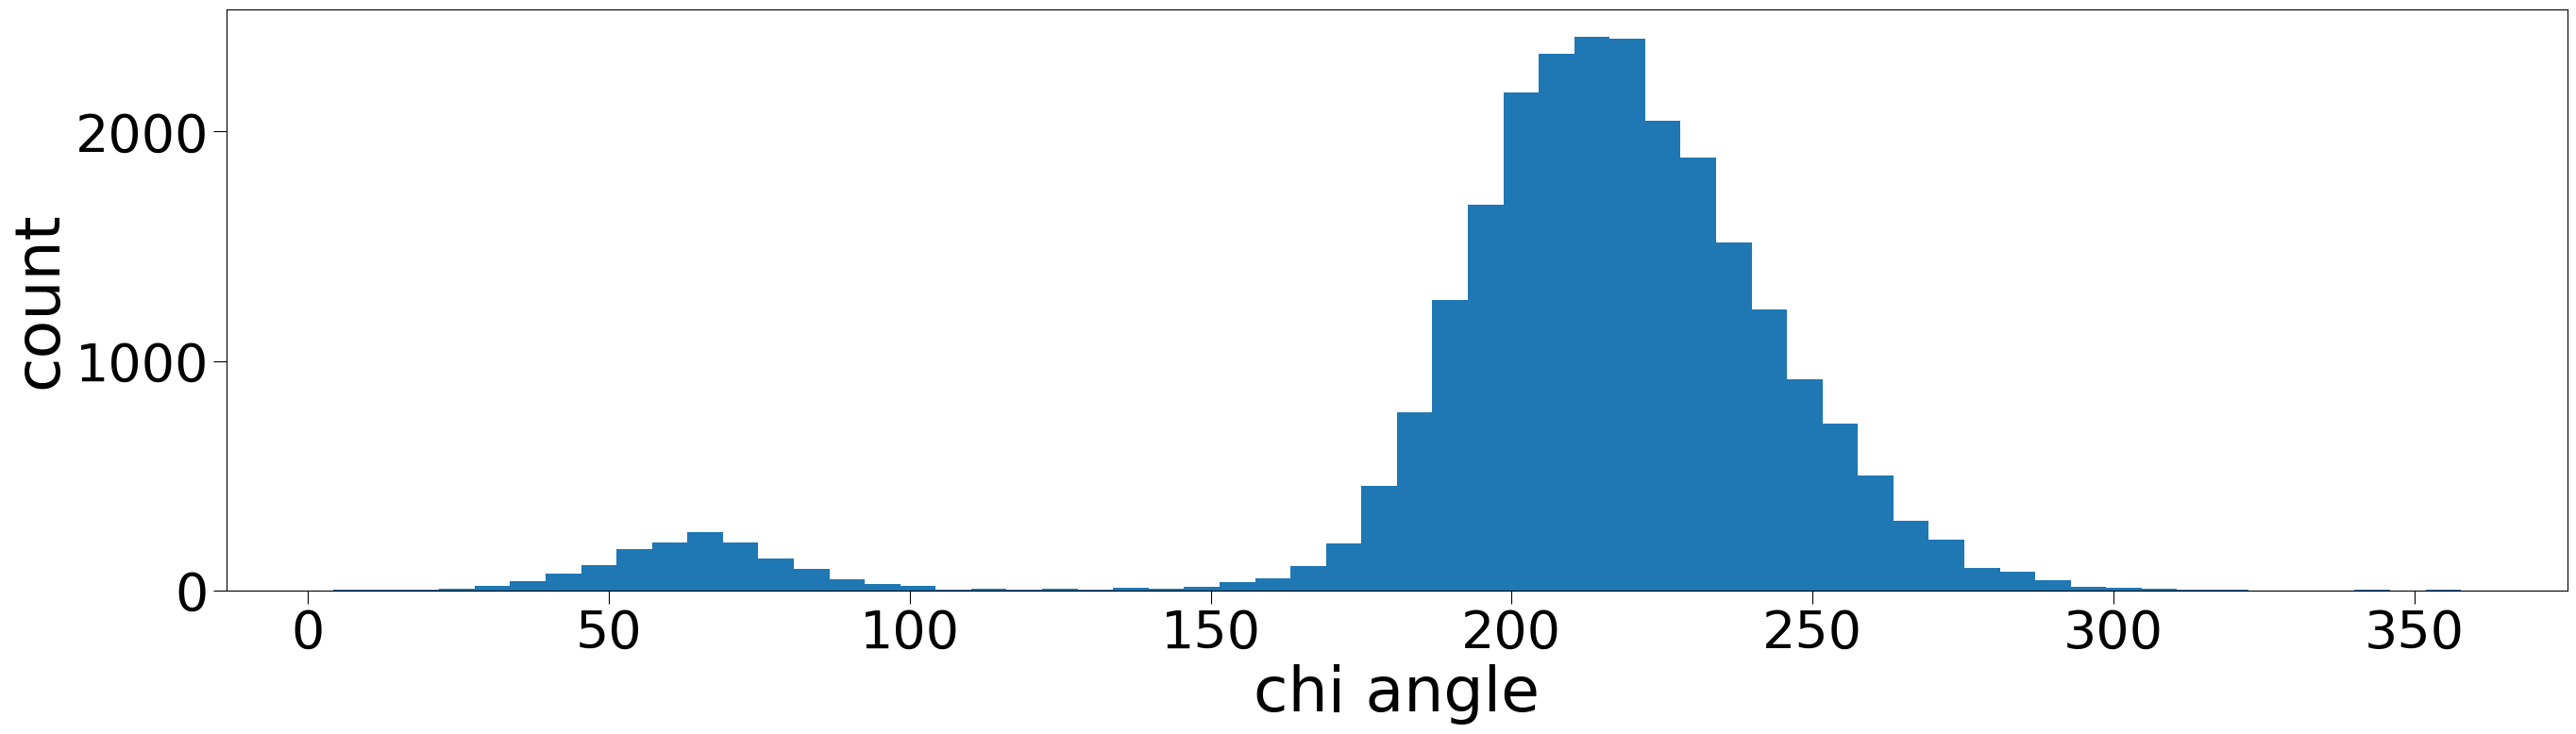

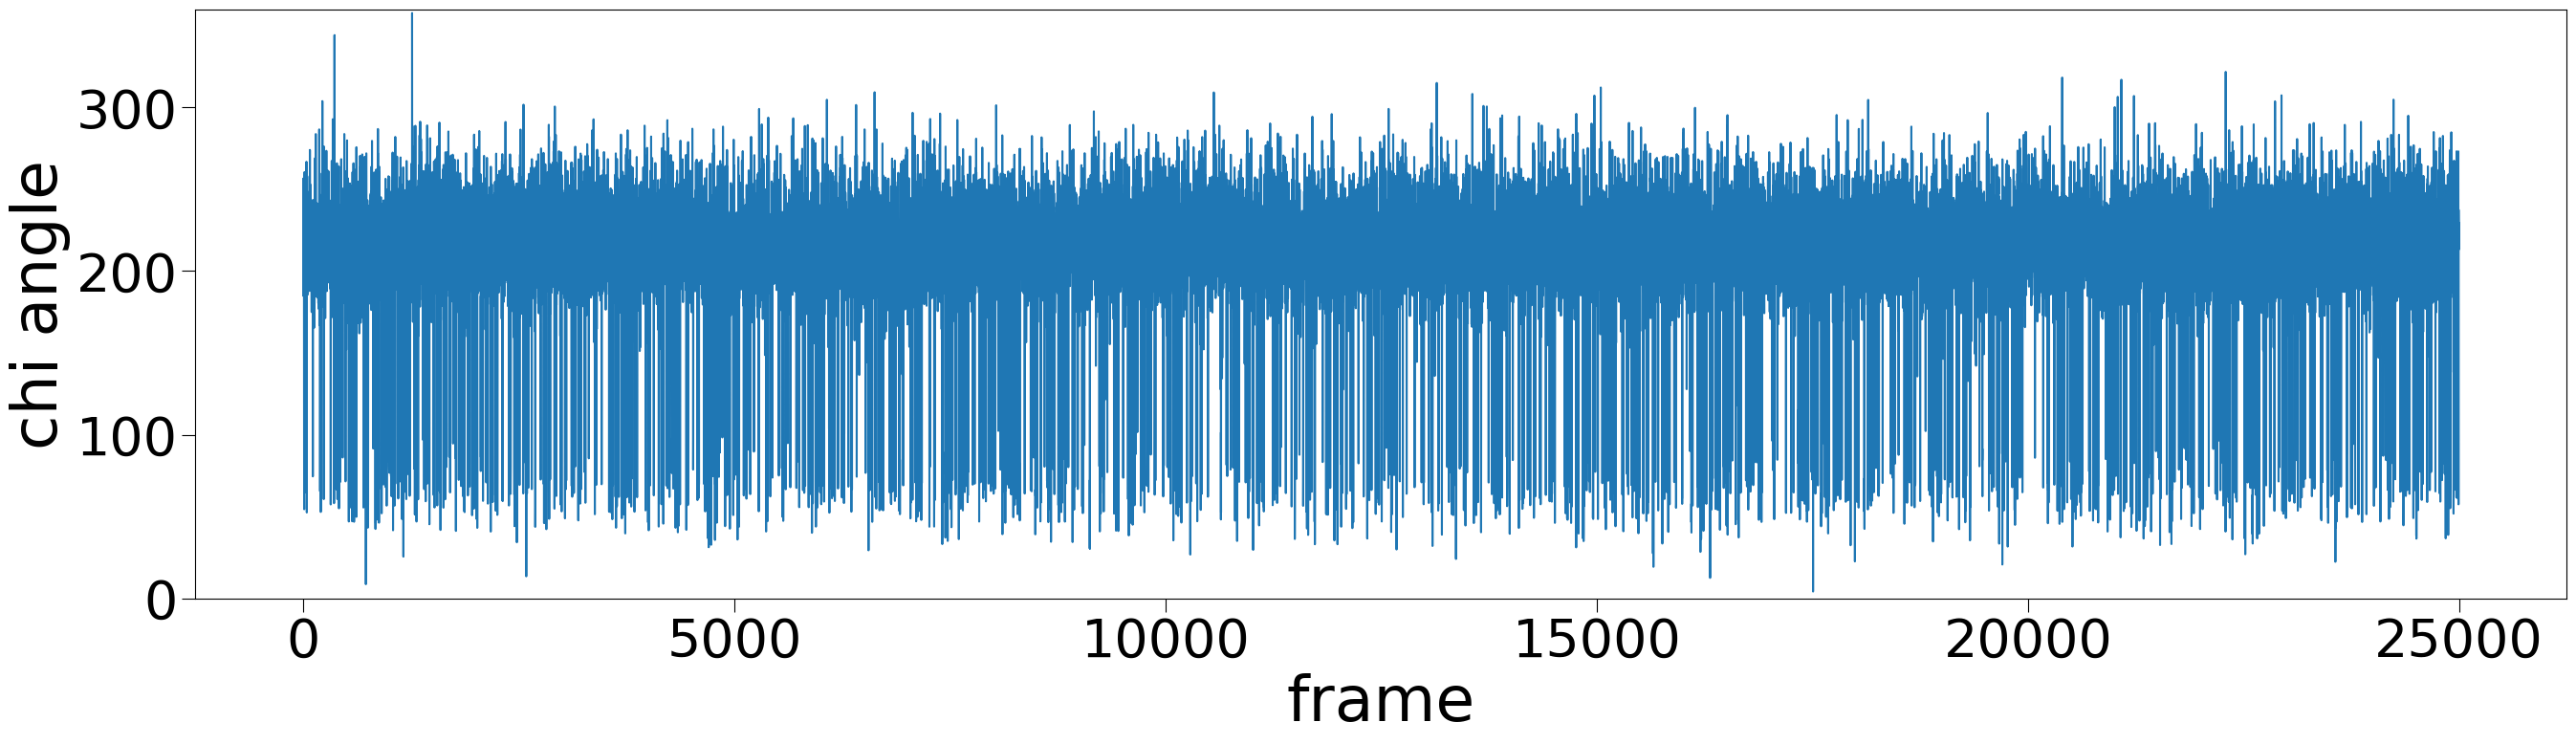

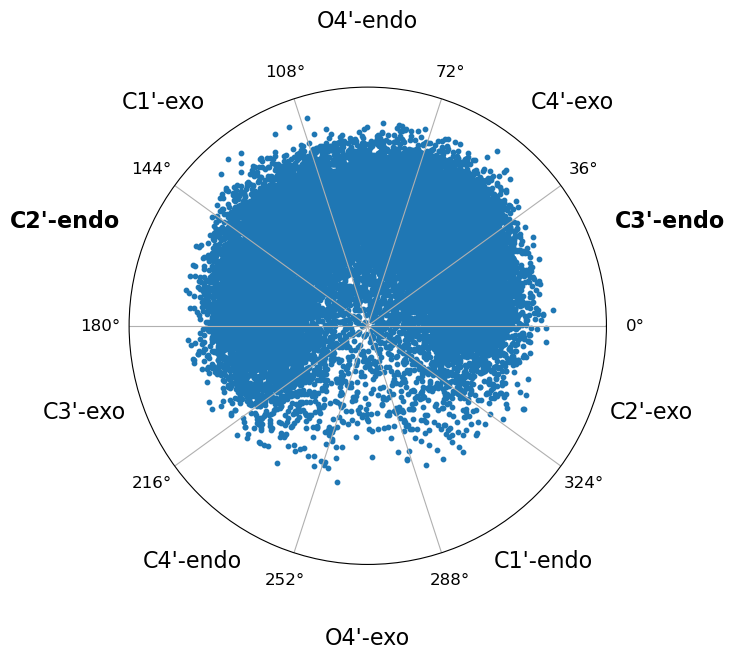

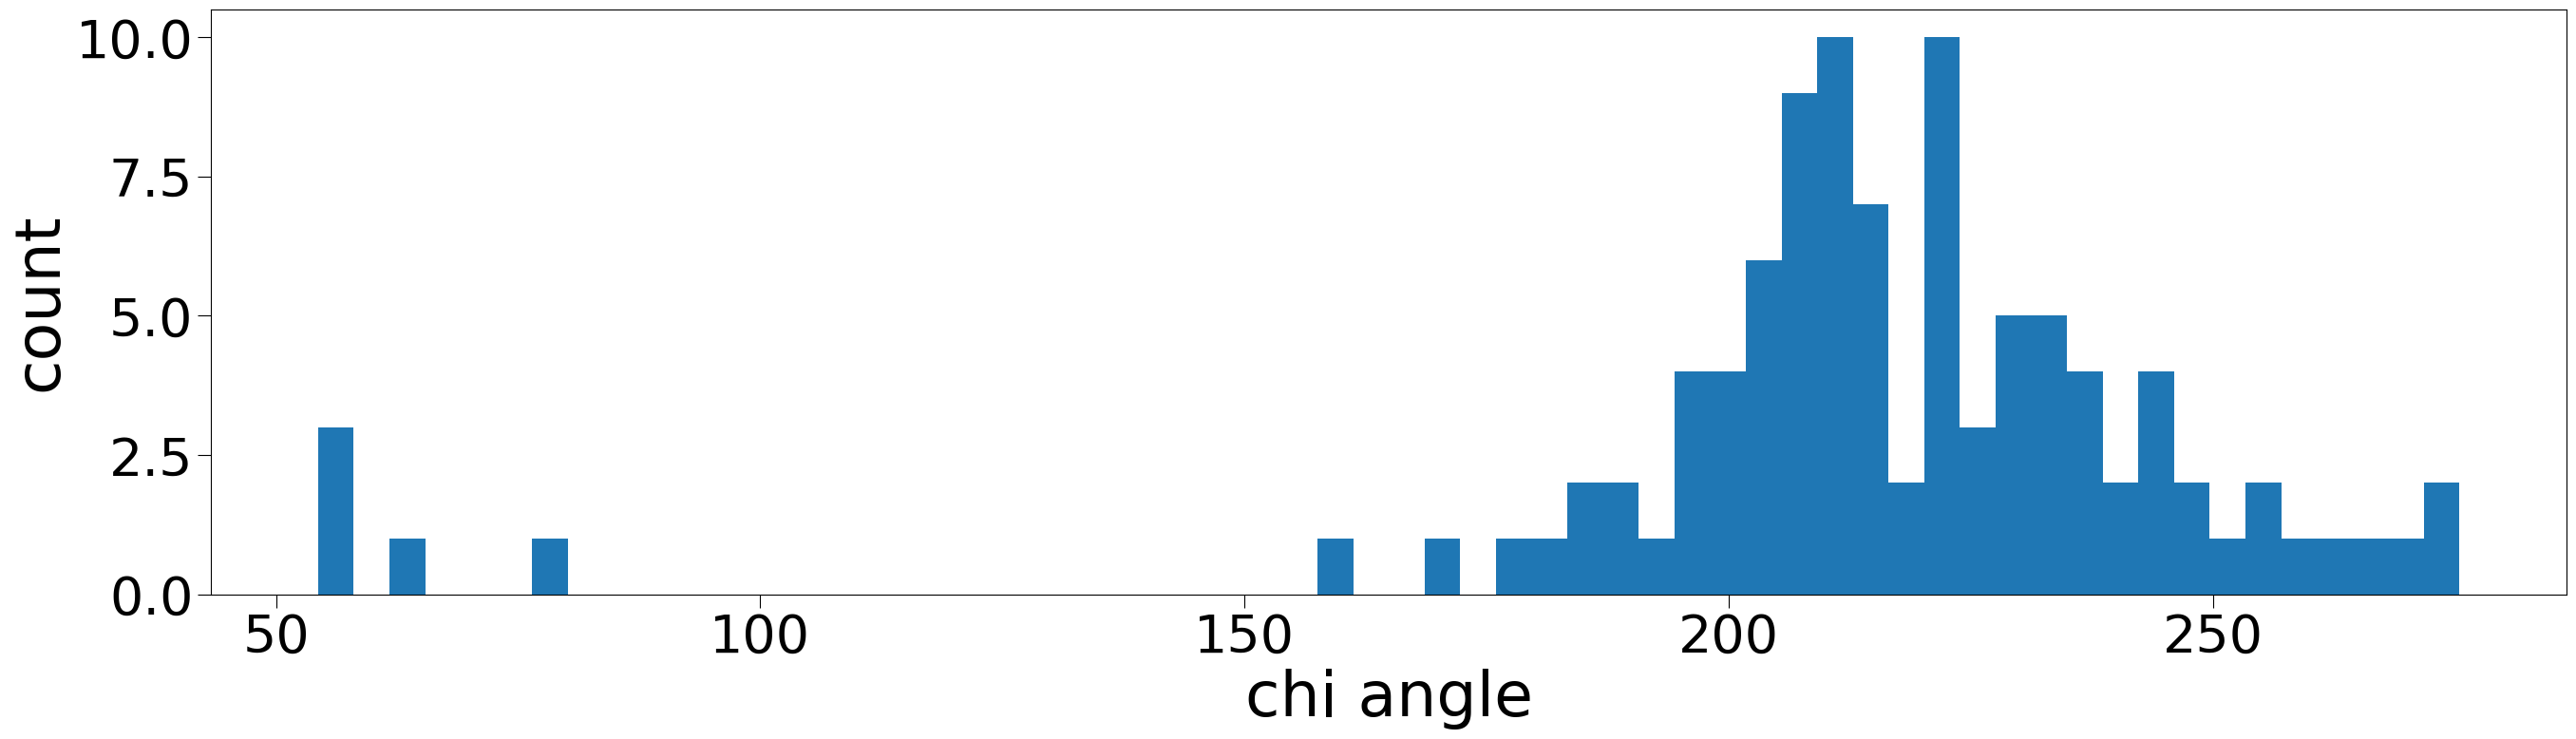

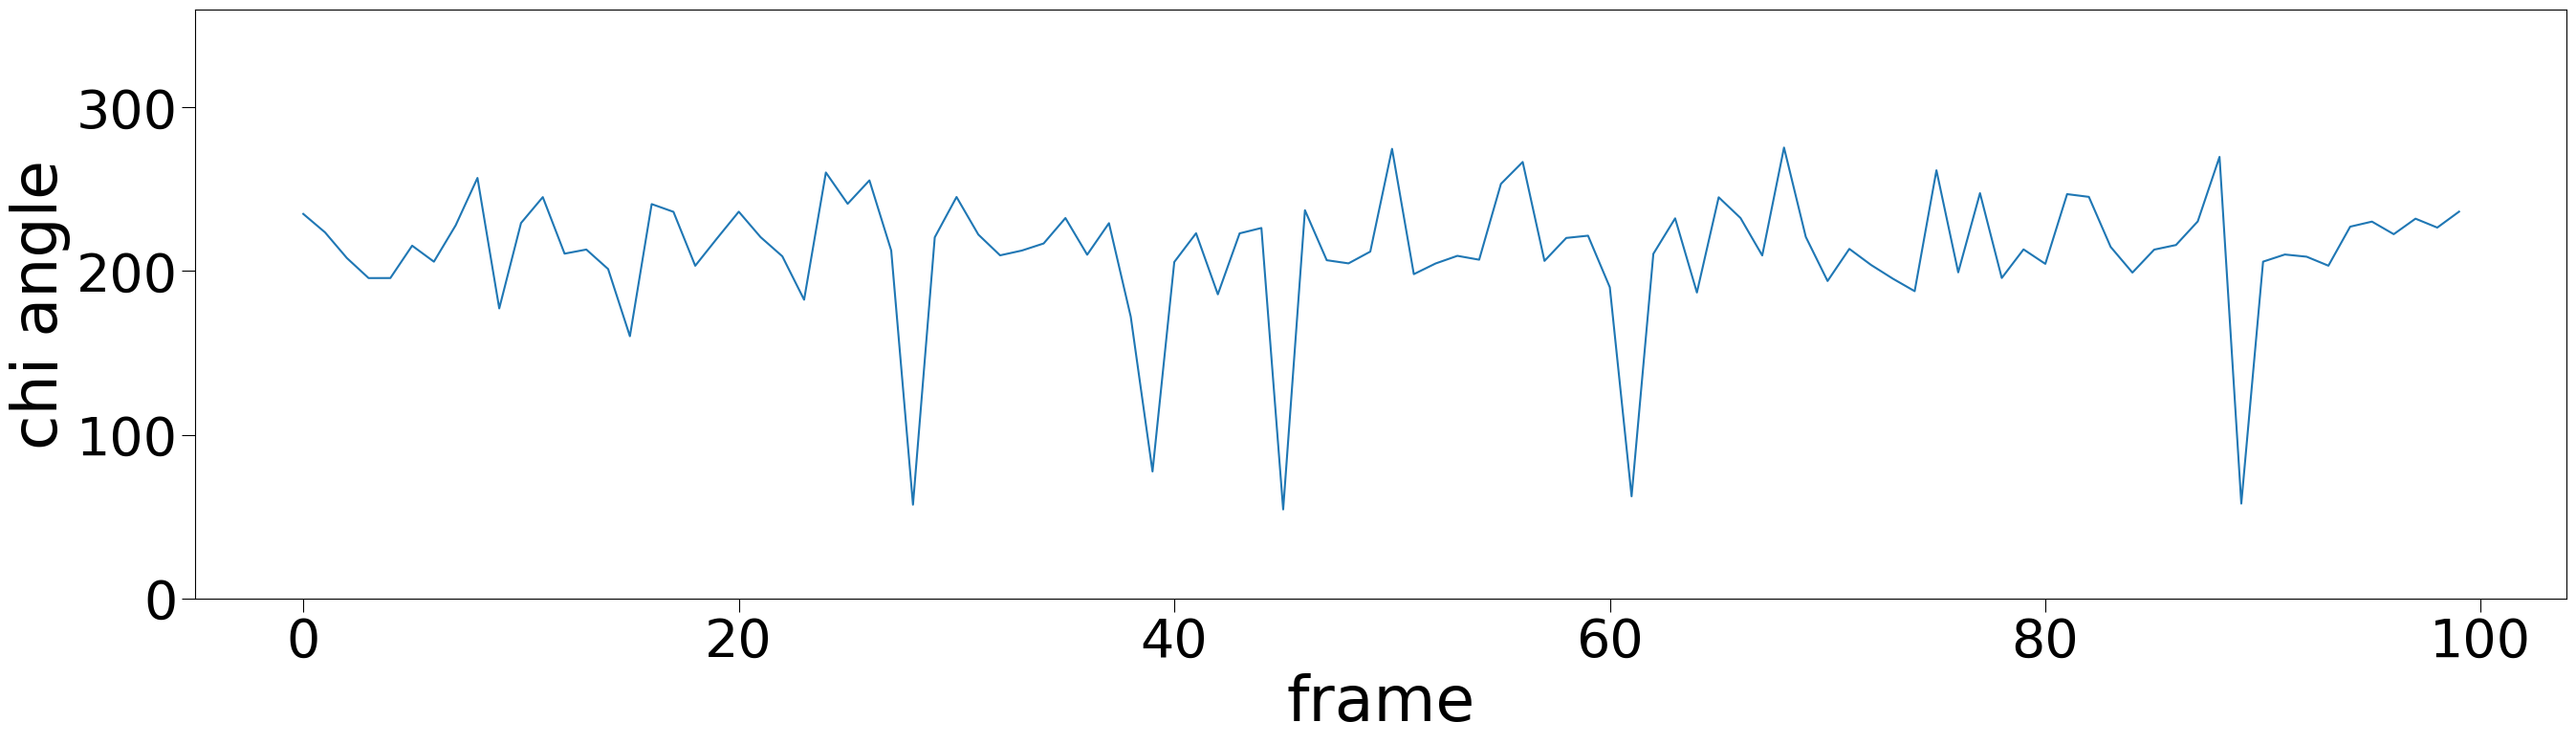

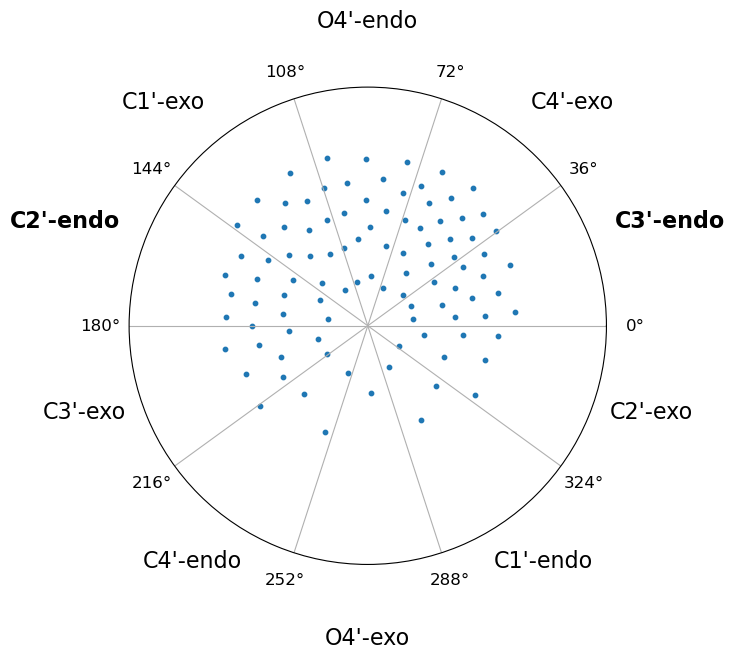

In [10]:
files = glob.glob("../md/c*/traj.nc")
run(files, n_clusters)

#### guanosine

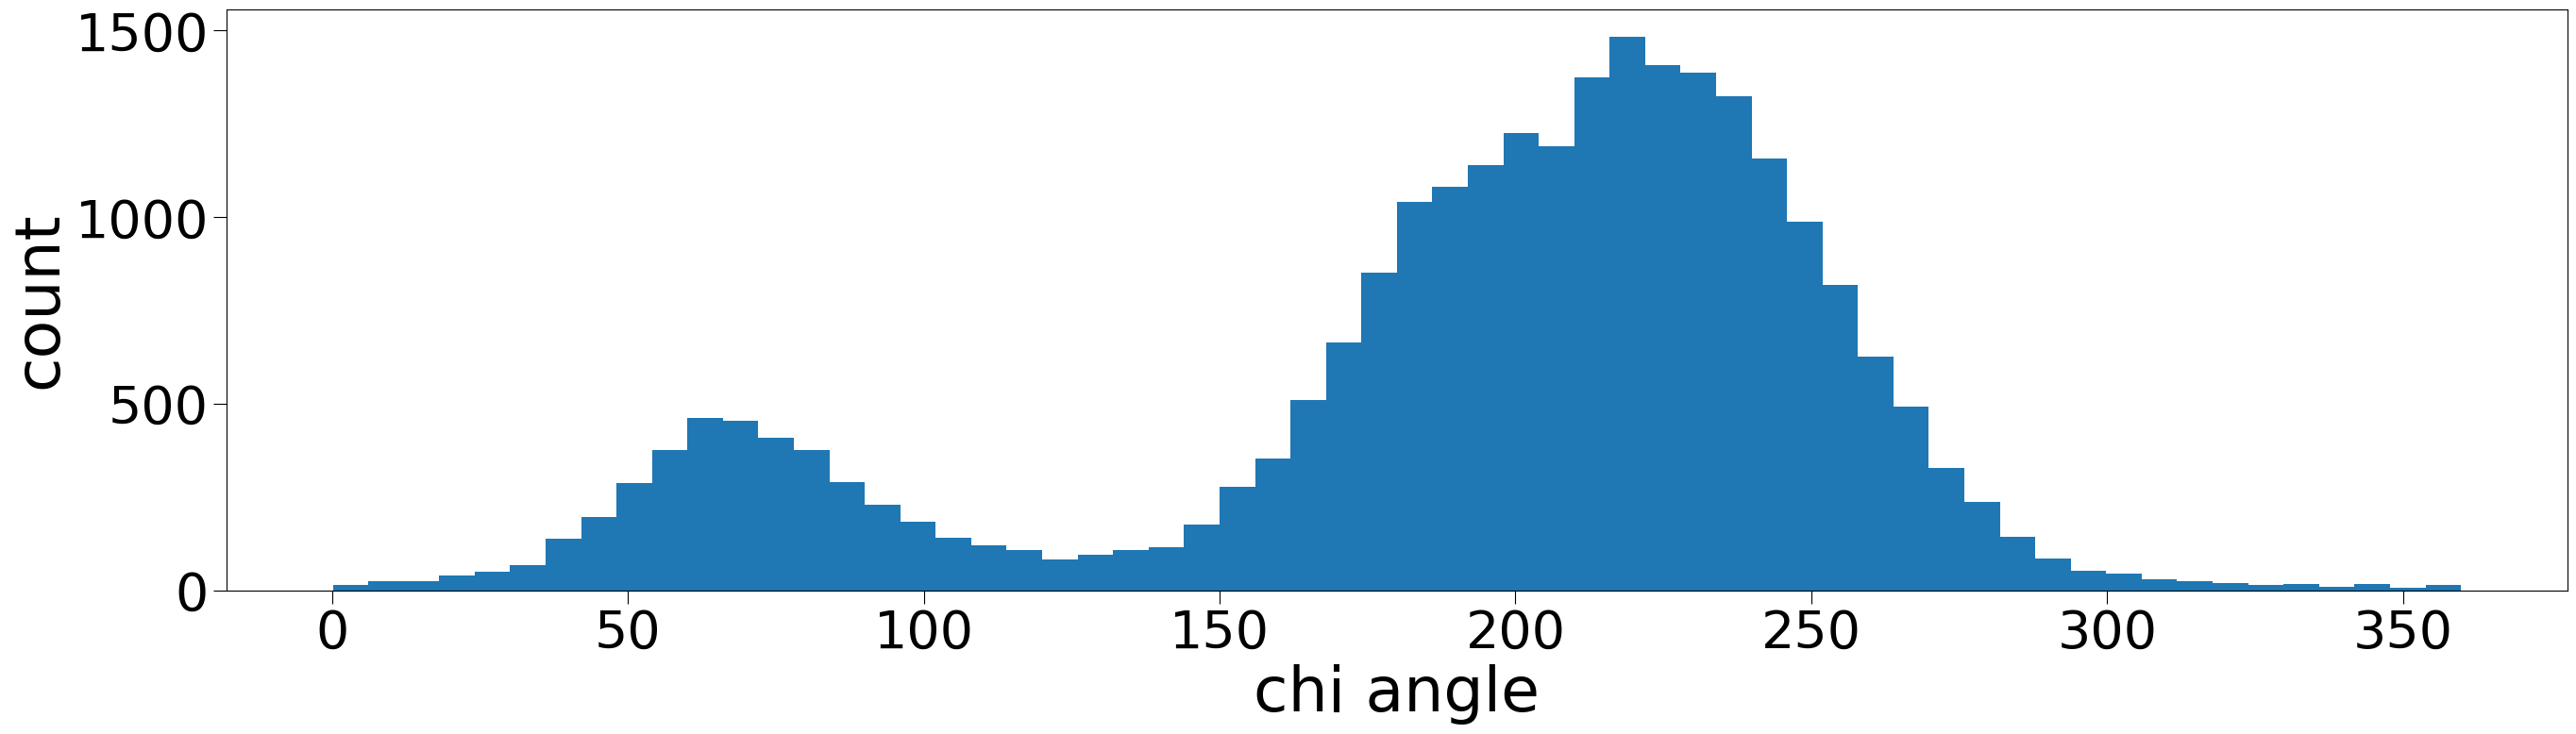

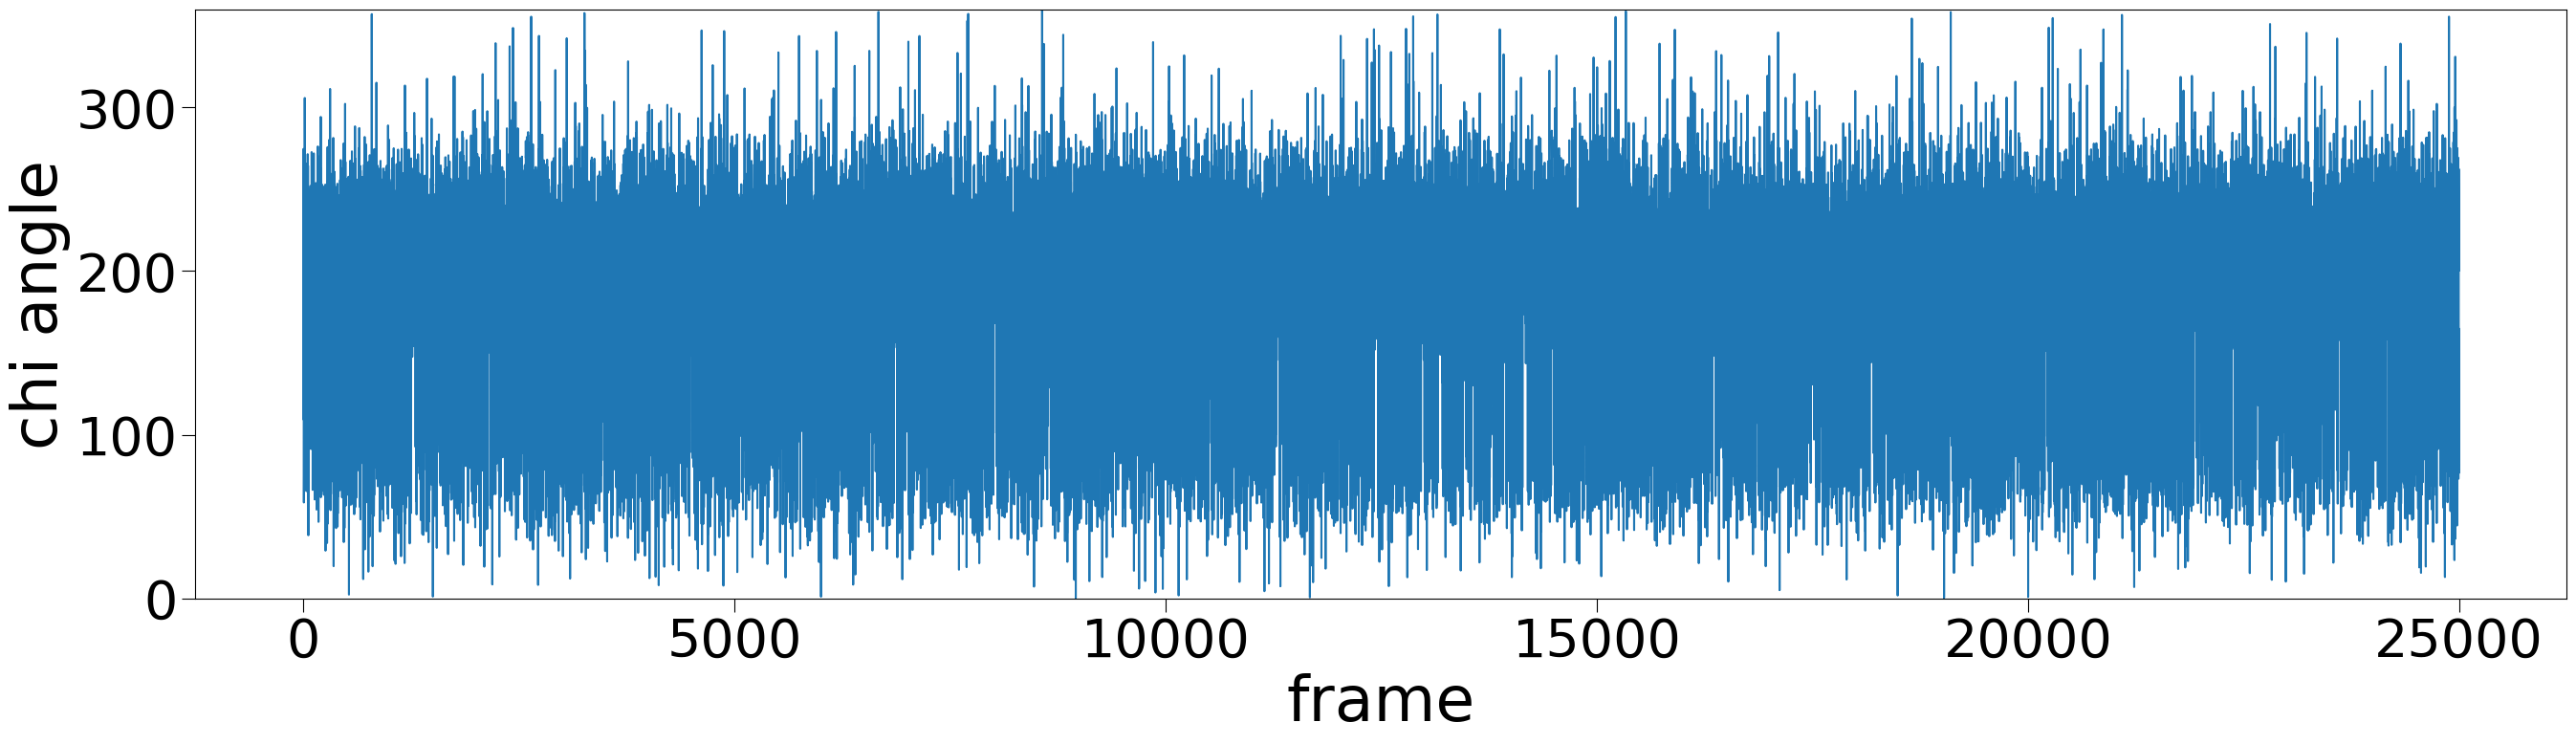

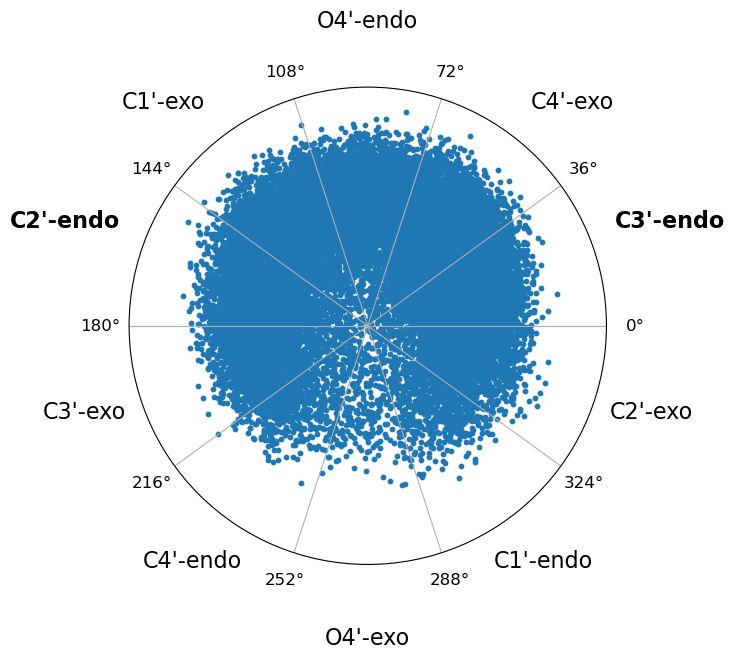

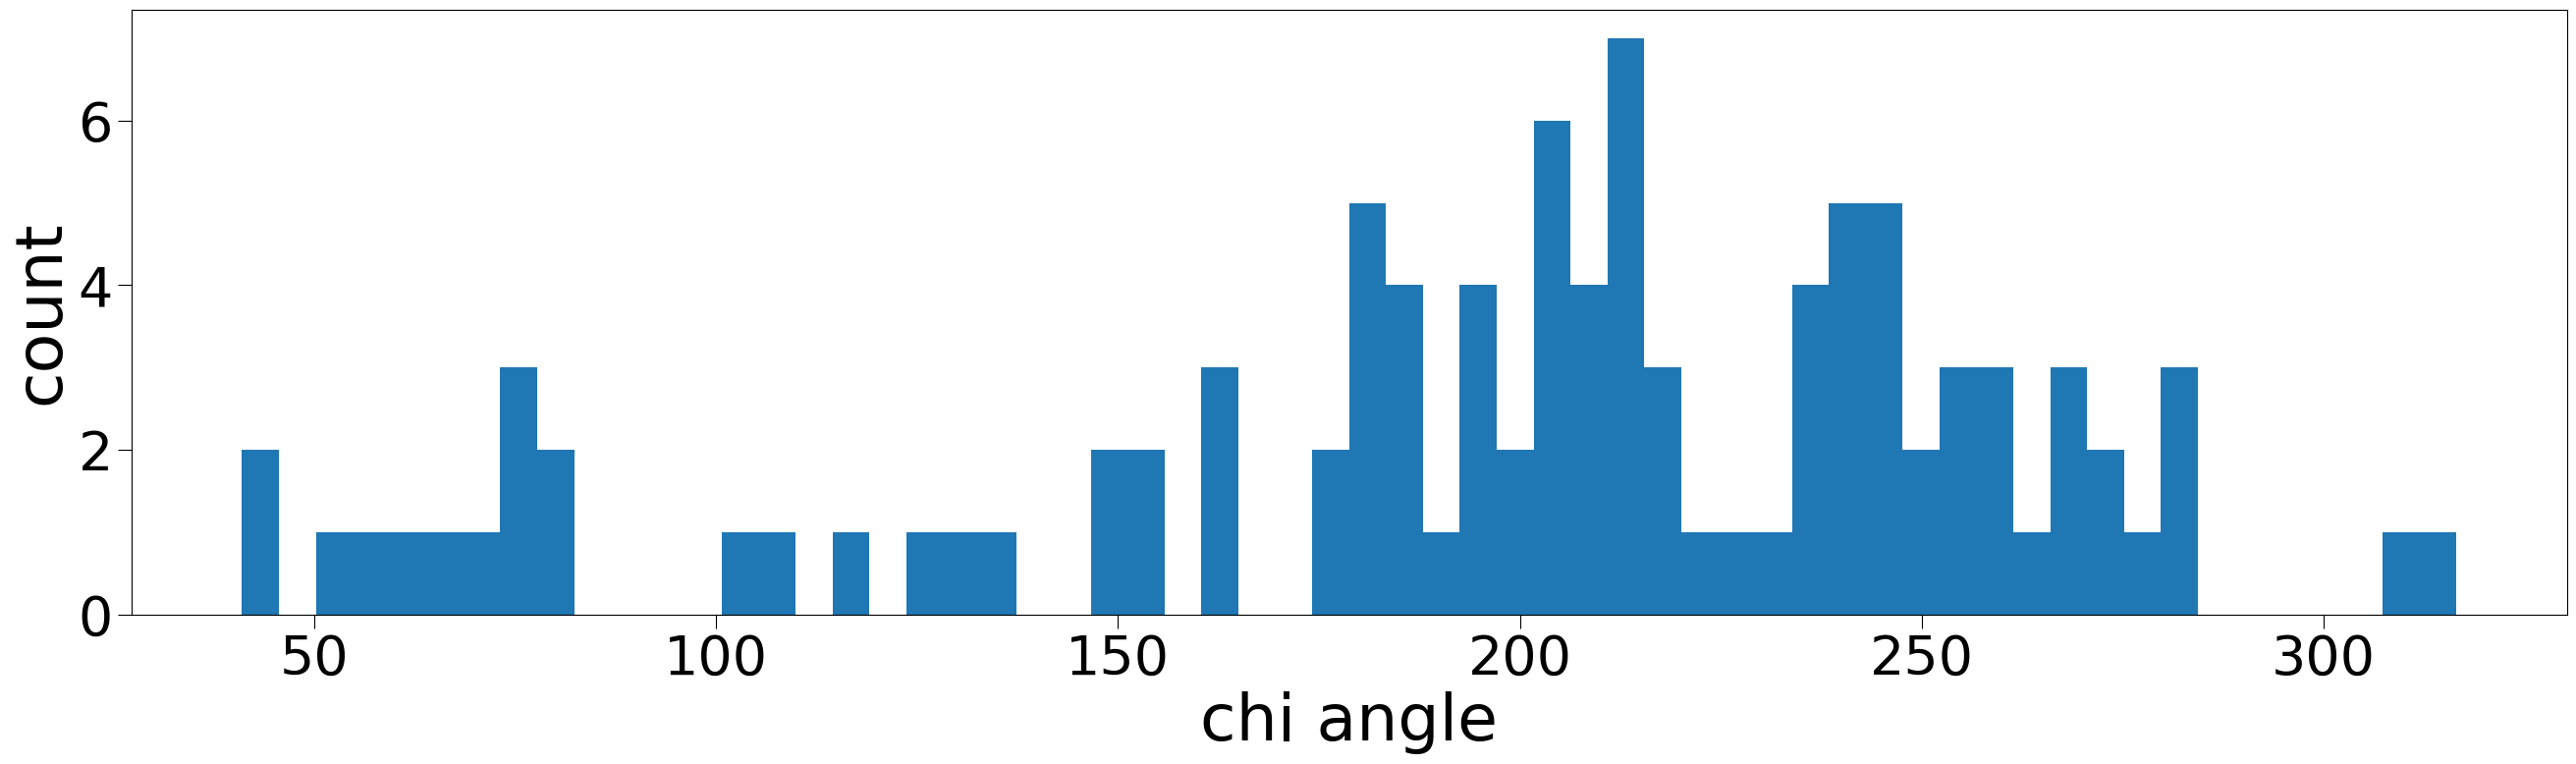

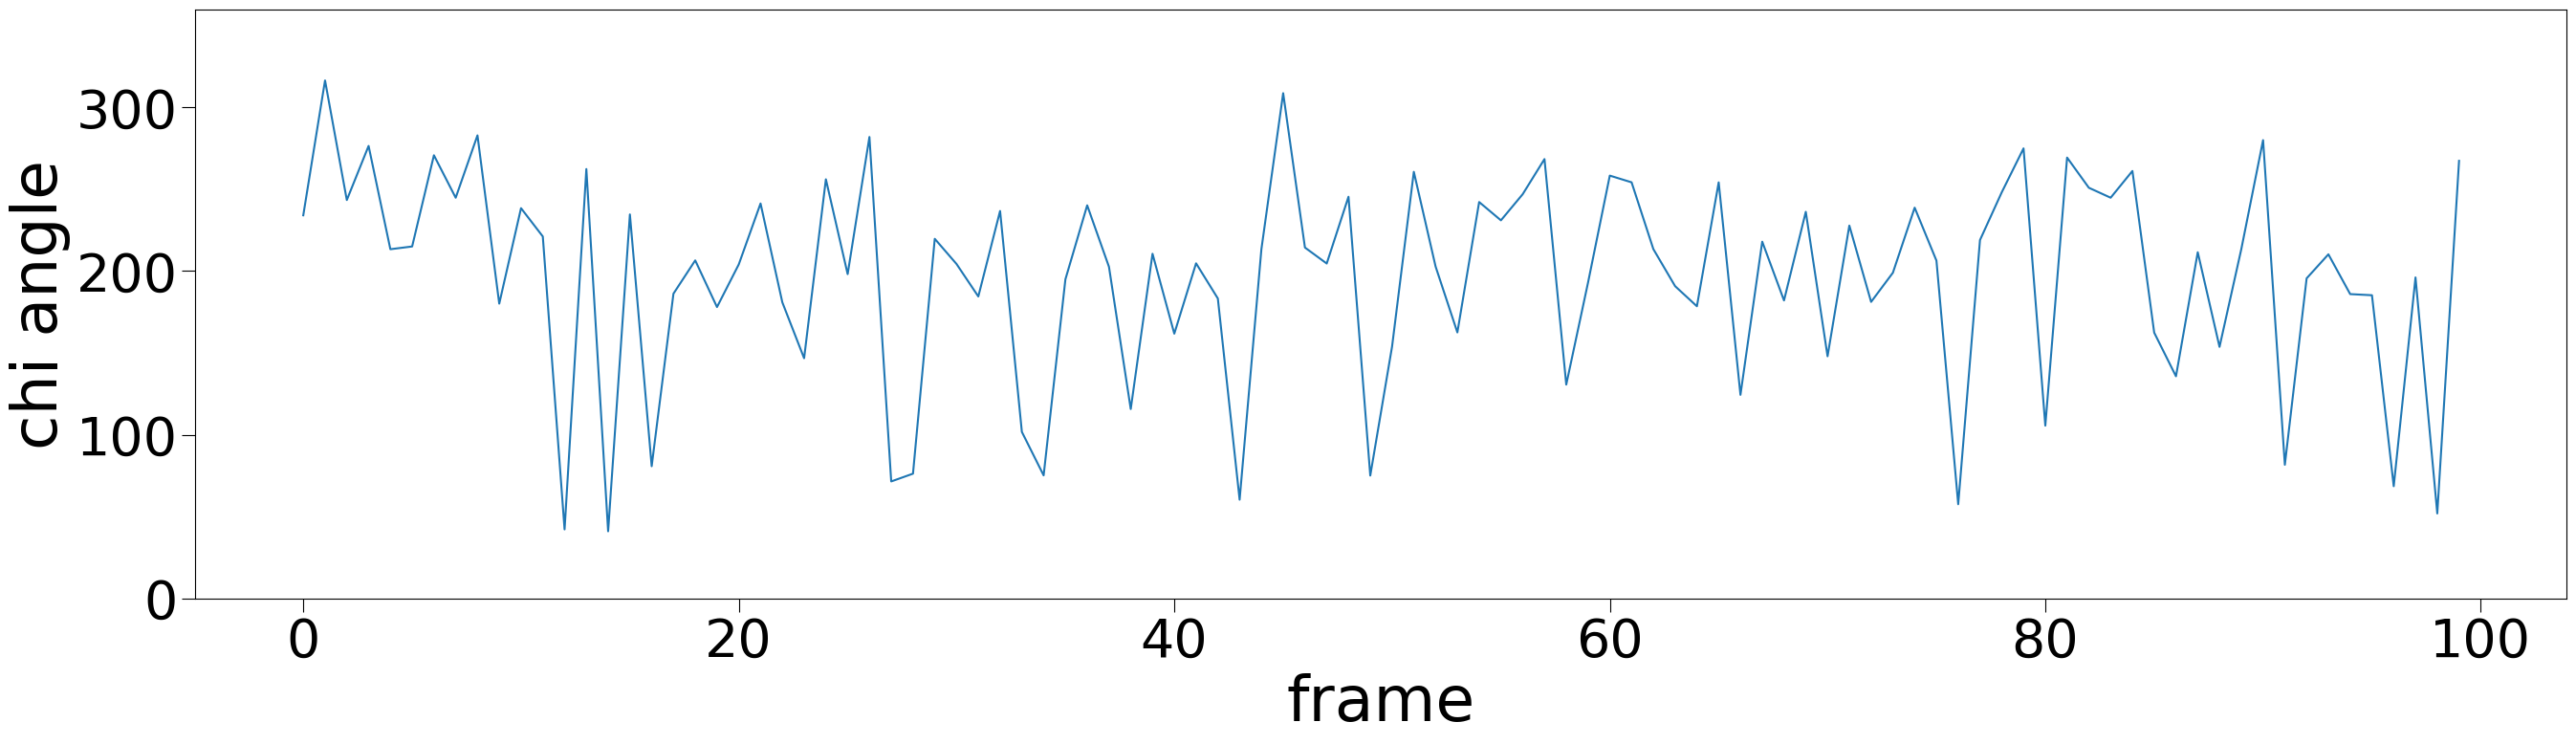

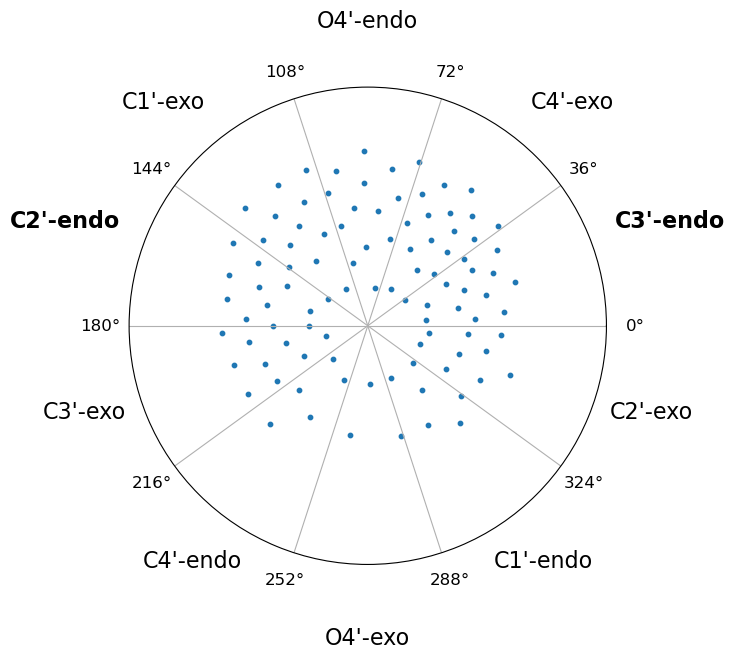

In [11]:
files = glob.glob("../md/g*/traj.nc")
run(files, n_clusters)

#### uridine

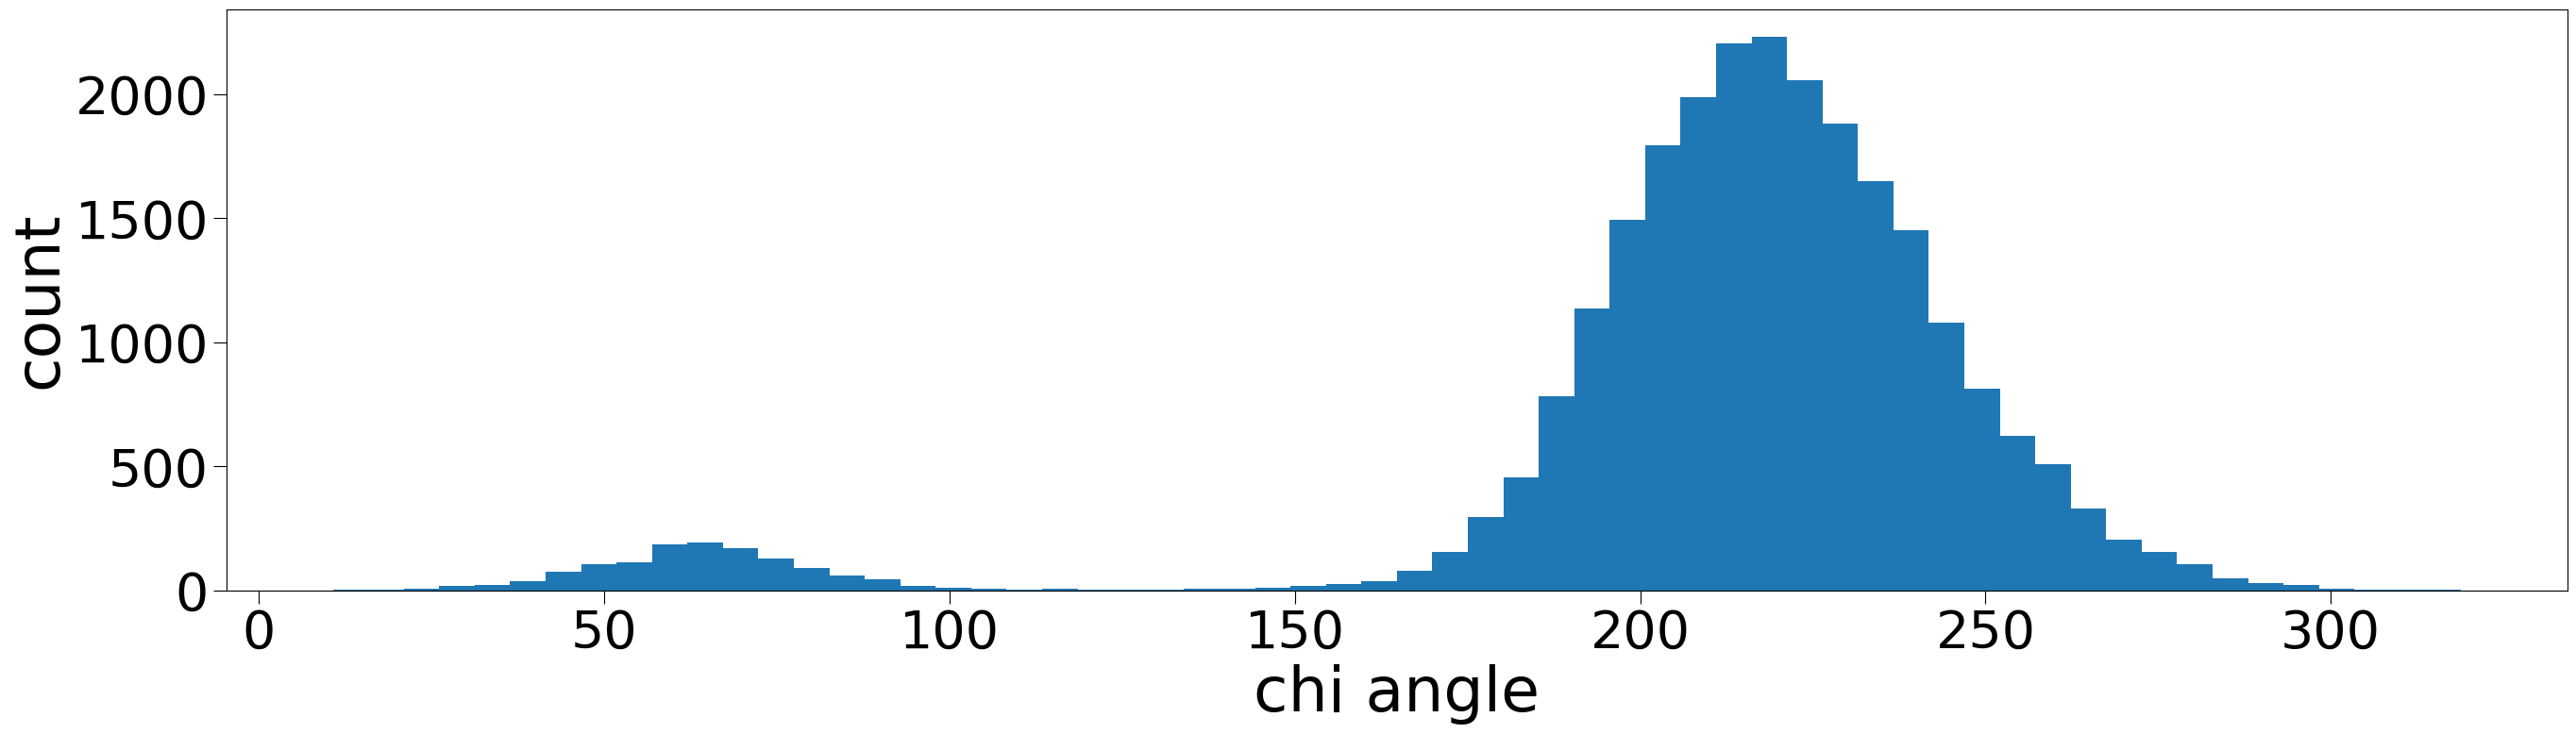

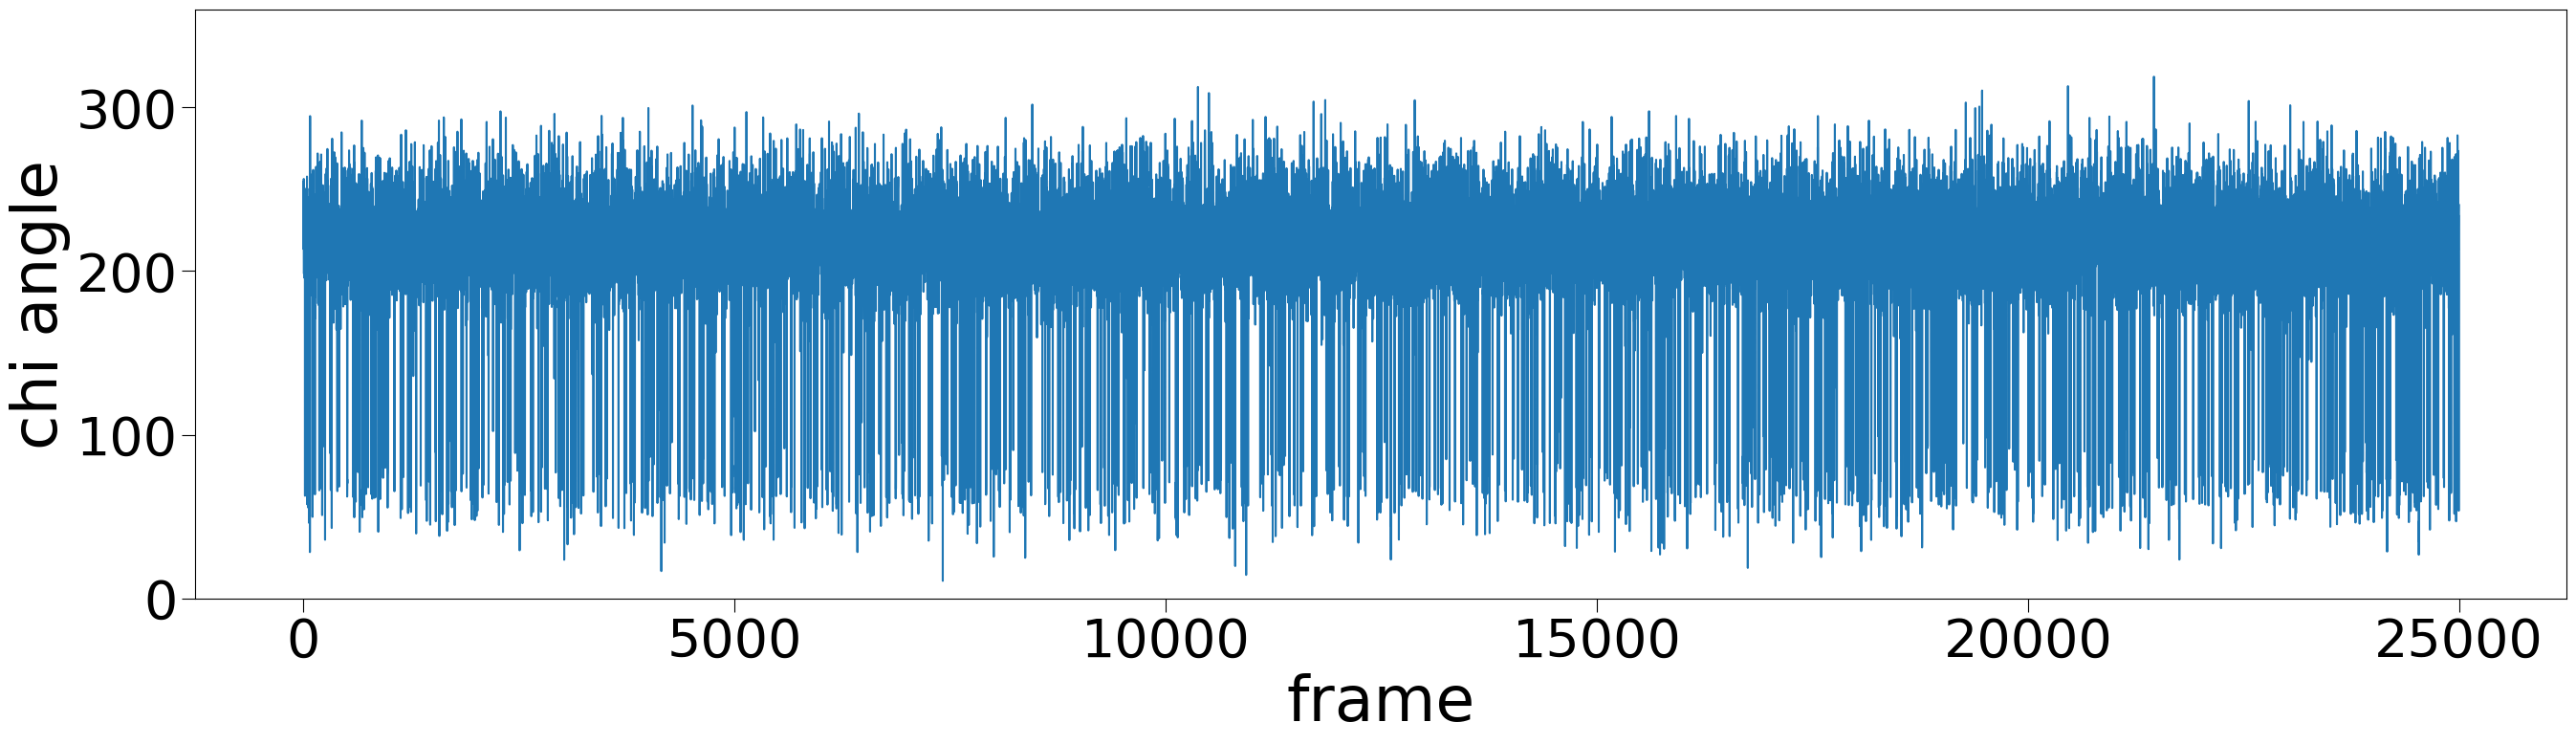

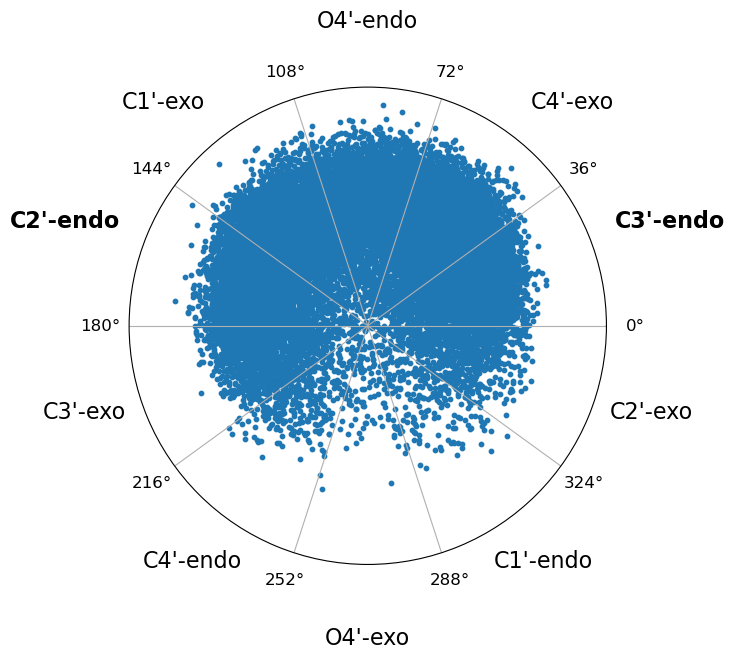

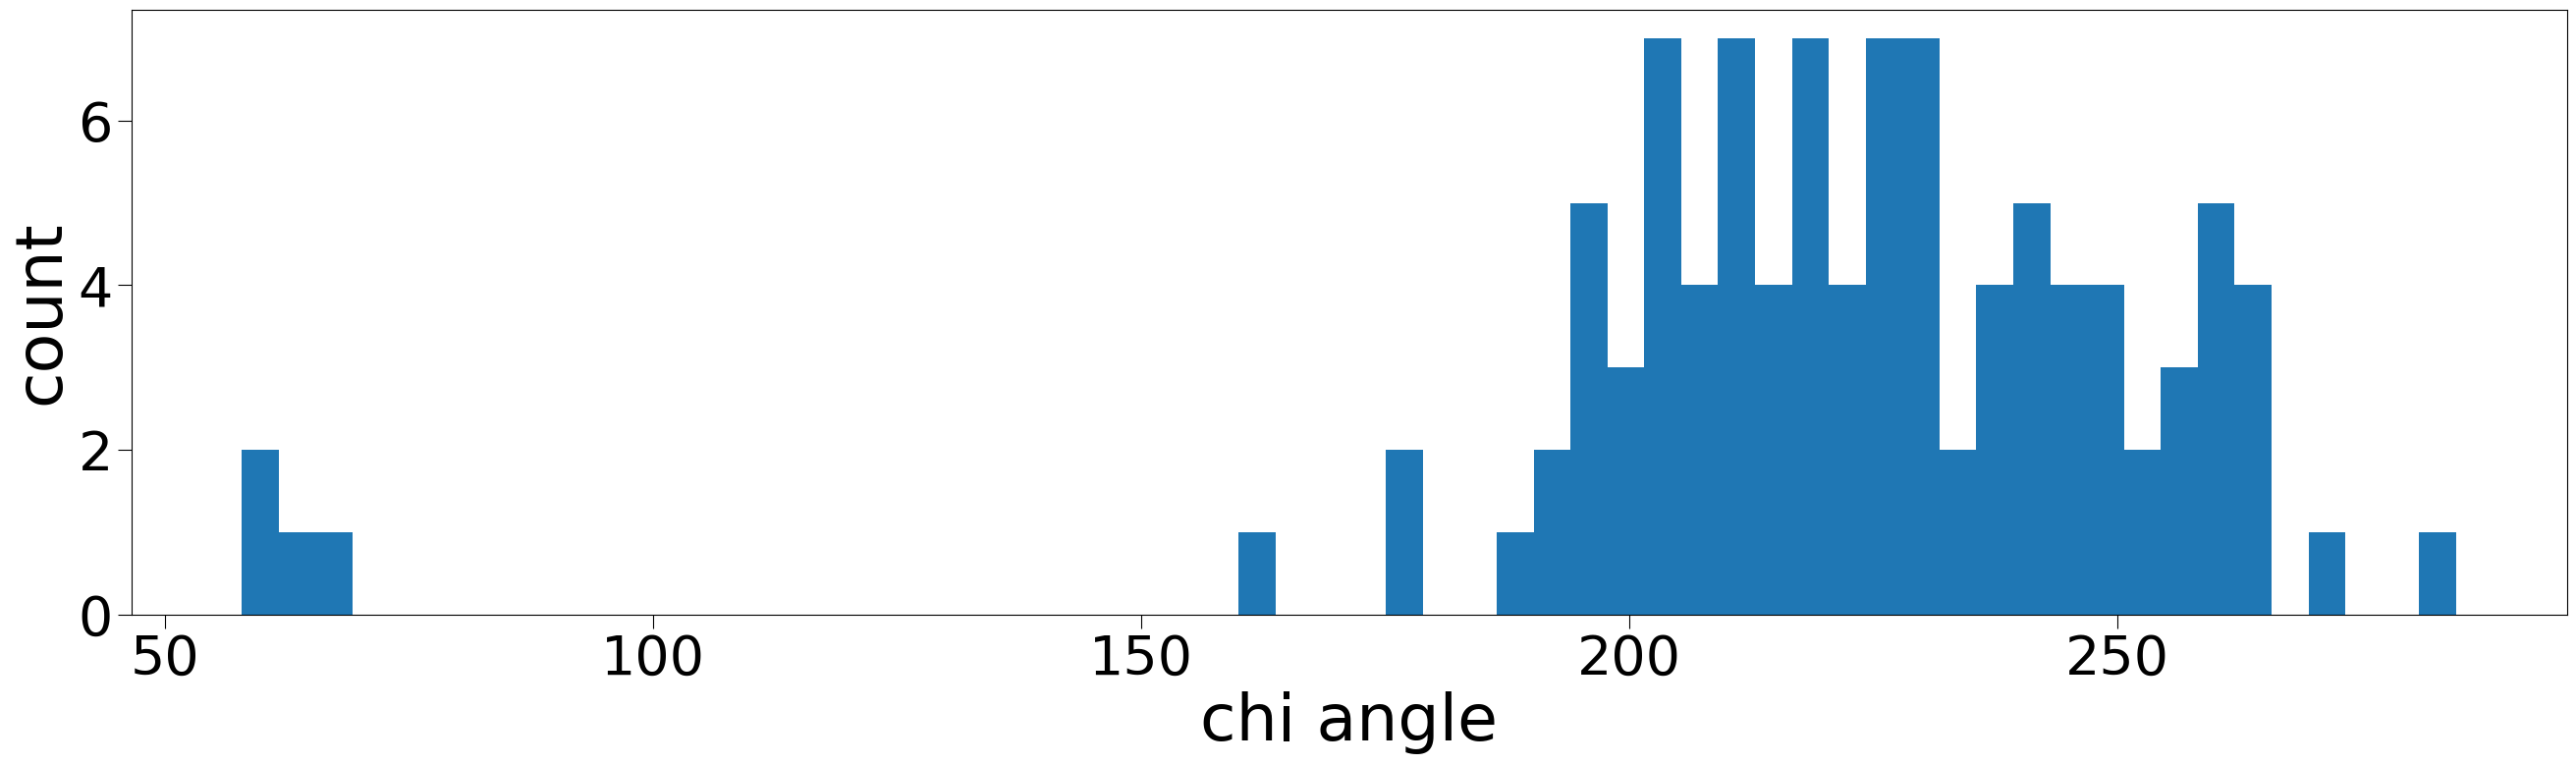

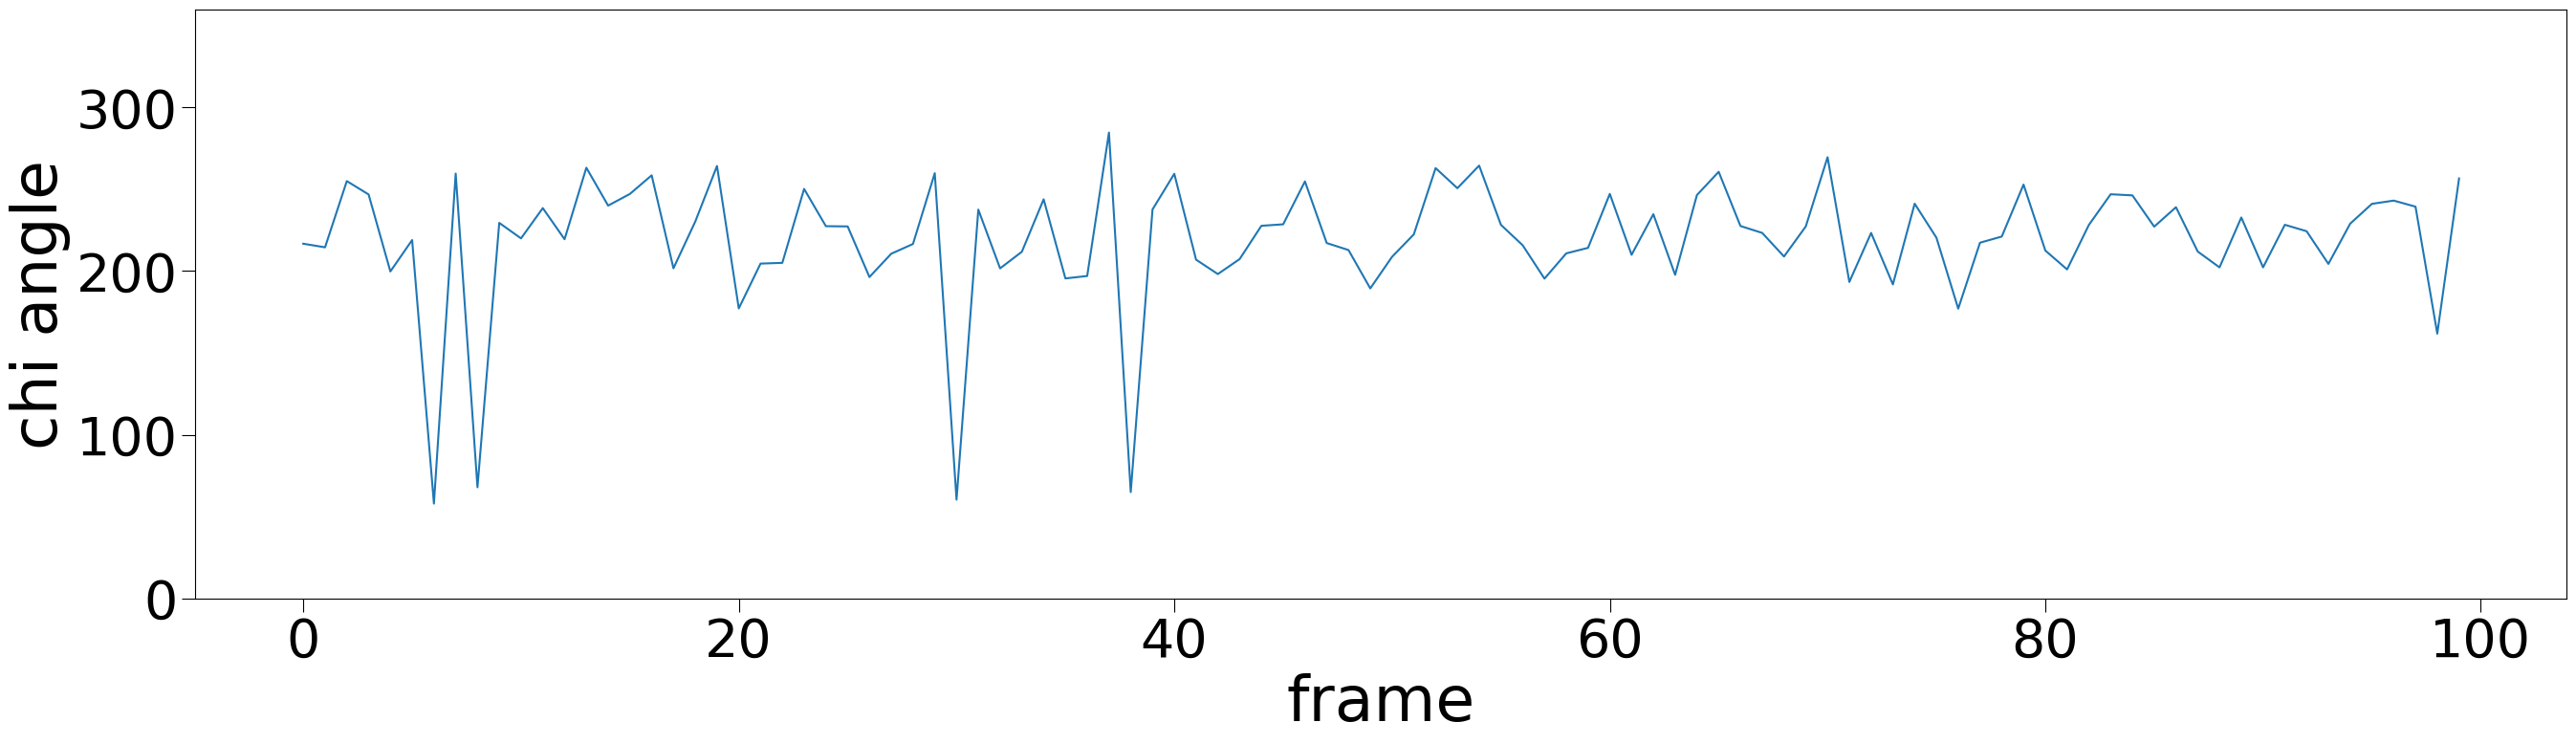

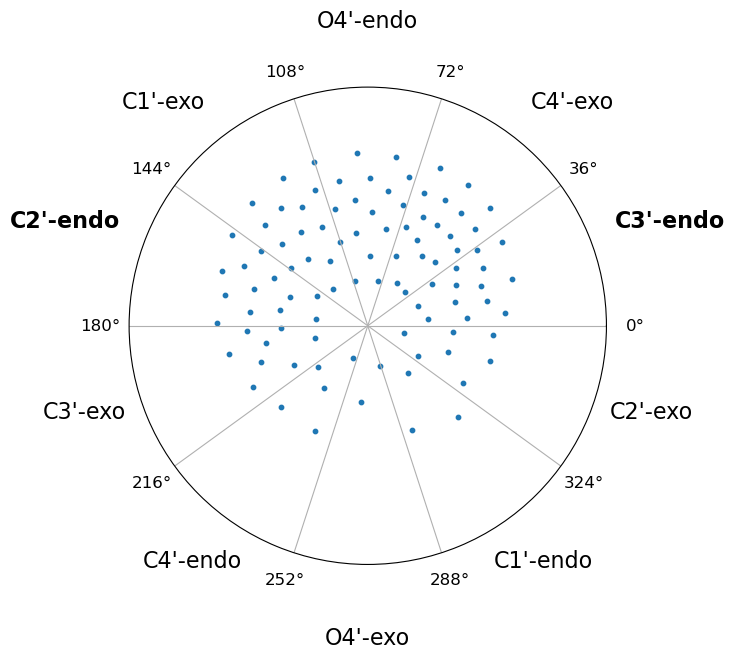

In [12]:
files = glob.glob("../md/u*/traj.nc")
run(files, n_clusters)

## 2. Torsion scan

Perform torsion scan against chi dihedral angle using RDKit. Clustered sugar pucker structures used as input structures.
 
https://future-chem.com/rdkit-constrained-conformer/  
https://greglandrum.github.io/rdkit-blog/posts/2023-02-10-more-on-constrained-embedding.html

In [13]:
from openmm import unit
from openff.toolkit.topology import Molecule, Topology
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem import rdForceFieldHelpers
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

In [14]:
def torsion_scan(rdmols, chi_atoms, restraint_atoms, output_suffix, minimize=False):
    if minimize == False:
        output_suffix = output_suffix + "_nomin"
    
    # store energies after torsion scan
    energies = []
    
    with Chem.SDWriter(f'torsion_scan_{output_suffix}.sdf') as w:
        for i, rdmol in enumerate(rdmols):            
            # minimize structure before torsion scan
            if minimize == True:
                prop = rdForceFieldHelpers.MMFFGetMoleculeProperties(rdmol)
                ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(rdmol, prop)   # MMFF94
                for atom_idx in restraint_atoms:
                    ff.MMFFAddPositionConstraint(atom_idx, 0.01, 1e2)
                ff.Minimize(maxIts=100)
                del prop, ff

            # torsion scan
            # Note: Structures will be relaxed later with openmm and filter high energy conformers using openff force field.
            for dihedral_degree in range(0, 360, 15):
                conf = rdmol.GetConformer()
                rdMolTransforms.SetDihedralDeg(conf, chi_atoms[0], chi_atoms[1], chi_atoms[2], chi_atoms[3], dihedral_degree)
                angle = rdMolTransforms.GetDihedralDeg(conf, chi_atoms[0], chi_atoms[1], chi_atoms[2], chi_atoms[3])
                
                prop = rdForceFieldHelpers.MMFFGetMoleculeProperties(rdmol)
                ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(rdmol, prop)
                
                #if minimize == True:
                #    prop = rdForceFieldHelpers.MMFFGetMoleculeProperties(rdmol)
                #    ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(rdmol, prop)                
                #    if minimize == True:
                #        for atom_idx in restraint_atoms:
                #            ff.MMFFAddPositionConstraint(atom_idx, 0.05, 1e2)
                #        ff.MMFFAddTorsionConstraint(chi_atoms[0], chi_atoms[1], chi_atoms[2], chi_atoms[3], False, dihedral_degree-2.5, dihedral_degree+2.5, 1e2)
                #        ff.Minimize(maxIts=5)

                energy = ff.CalcEnergy()
                energies.append(energy)
                
                # add property to rdmol
                molname = str(output_suffix)+str(i)
                rdmol.SetProp('_Name', f'{molname}')
                
                # export sdf
                w.write(rdmol)

    return energies

In [15]:
def split_rdconfs_to_rdmols(_rdmols, chi_atoms):    
    # seperate rdmol conformers as individual rdmols
    rdmols = []
    for conf in _rdmols.GetConformers():
        _rdmol = Chem.Mol(_rdmols)
        _rdmol.RemoveAllConformers()
        _rdmol.AddConformer(conf)
        rdmols.append(_rdmol)

    return rdmols

In [16]:
def offmol_to_rdmol(name):
    # initialize
    traj = mdtraj.load(f"traj_cls_{name}.nc", top=f"../md/crd/{name}.pdb")
    unique_molecules = Molecule.from_file(f"../md/crd/{name}.sdf")
    topology = Topology.from_openmm(traj[0].topology.to_openmm(), unique_molecules=[unique_molecules])
    mols = Molecule.from_topology(topology)

    # add conformers
    for i in range(len(traj)):
        xyz = np.array(traj.openmm_positions(i)._value)
        mols.add_conformer(unit.Quantity(xyz, traj.openmm_positions(i).unit))

    # convert openff molecule to rdkit molecule
    _rdmols = mols.to_rdkit()
    
    return _rdmols

#### define energy threshold

In [17]:
energy_threshold = 100

#### define sugar

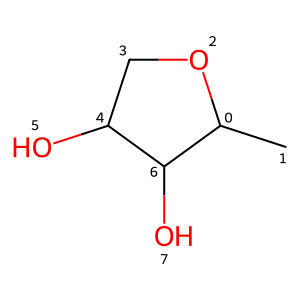

In [18]:
sugar = Chem.MolFromSmiles('C(C)1OCC(O)C(O)1')
sugar

#### adenosine

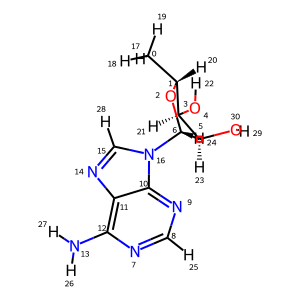

In [19]:
name = "a"

# convert clustered trajectories into openff molecule
# convert openff molecule into rdkit molecules
# rdMolTransforms.SetDihedralDeg() module in rdkit used for torsion scan
_rdmols = offmol_to_rdmol(name)
_rdmols

In [20]:
# convert rdkit conformers into seperate rdmol 
chi_atoms = [2, 6, 16, 10]
rdmols = split_rdconfs_to_rdmols(_rdmols, chi_atoms)

# get restraint atoms indices
restraint_atoms = list(rdmols[0].GetSubstructMatch(sugar))
print(restraint_atoms)

# torsion scan with positional restraints on sugar atoms
# exclude first entry (sdf structure)
energies = torsion_scan(rdmols[1:], chi_atoms, restraint_atoms, name, minimize=False)
energies = torsion_scan(rdmols[1:], chi_atoms, restraint_atoms, name, minimize=True)

[1, 0, 2, 6, 5, 30, 3, 4]


total # of conformers:  2400
maximum energy:  892.4620659886466
minimum energy:  63.08348553155238
# conformers with relative energy >100 kcal/mol:  12


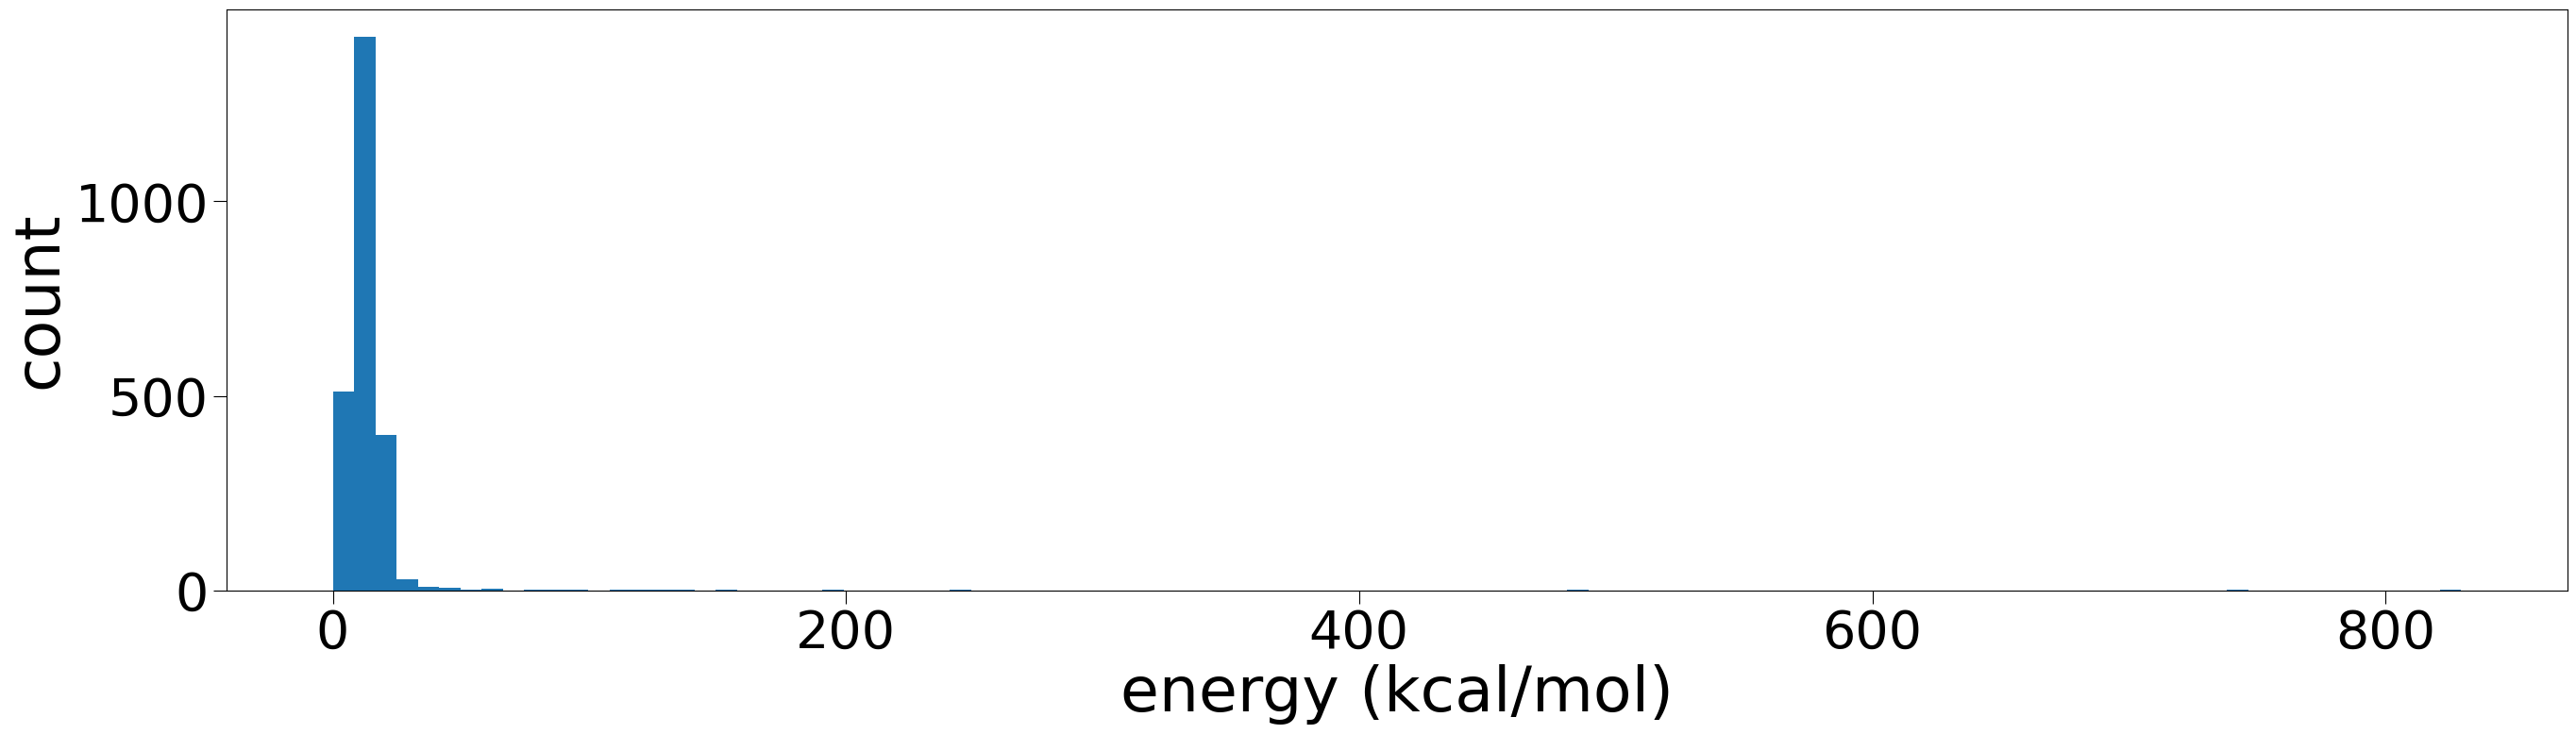

In [21]:
# check energy distribution

e = np.array(energies)  # unit: kcal/mol
emax = e.max()
emin = e.min()
print('total # of conformers: ', len(e))
print('maximum energy: ', emax)
print('minimum energy: ', emin)
print(f'# conformers with relative energy >{energy_threshold} kcal/mol: ', len(np.where(e-emin > energy_threshold)[0]))

plt.hist(e-emin, bins=100)
plt.xlabel('energy (kcal/mol)')
plt.ylabel('count')
plt.show()

#### cytidine

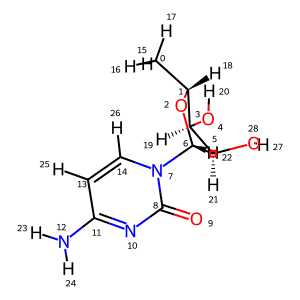

In [22]:
name = "c"
_rdmols = offmol_to_rdmol(name)
_rdmols

In [23]:
chi_atoms = [2, 6, 7, 8]
rdmols = split_rdconfs_to_rdmols(_rdmols, chi_atoms)

restraint_atoms = list(rdmols[0].GetSubstructMatch(sugar))
print(restraint_atoms)

energies = torsion_scan(rdmols[1:], chi_atoms, restraint_atoms, name, minimize=False)
energies = torsion_scan(rdmols[1:], chi_atoms, restraint_atoms, name, minimize=True)

[1, 0, 2, 6, 5, 28, 3, 4]


total # of conformers:  2400
maximum energy:  597.2296900231257
minimum energy:  -27.14019753354387
# conformers with relative energy >100 kcal/mol:  11


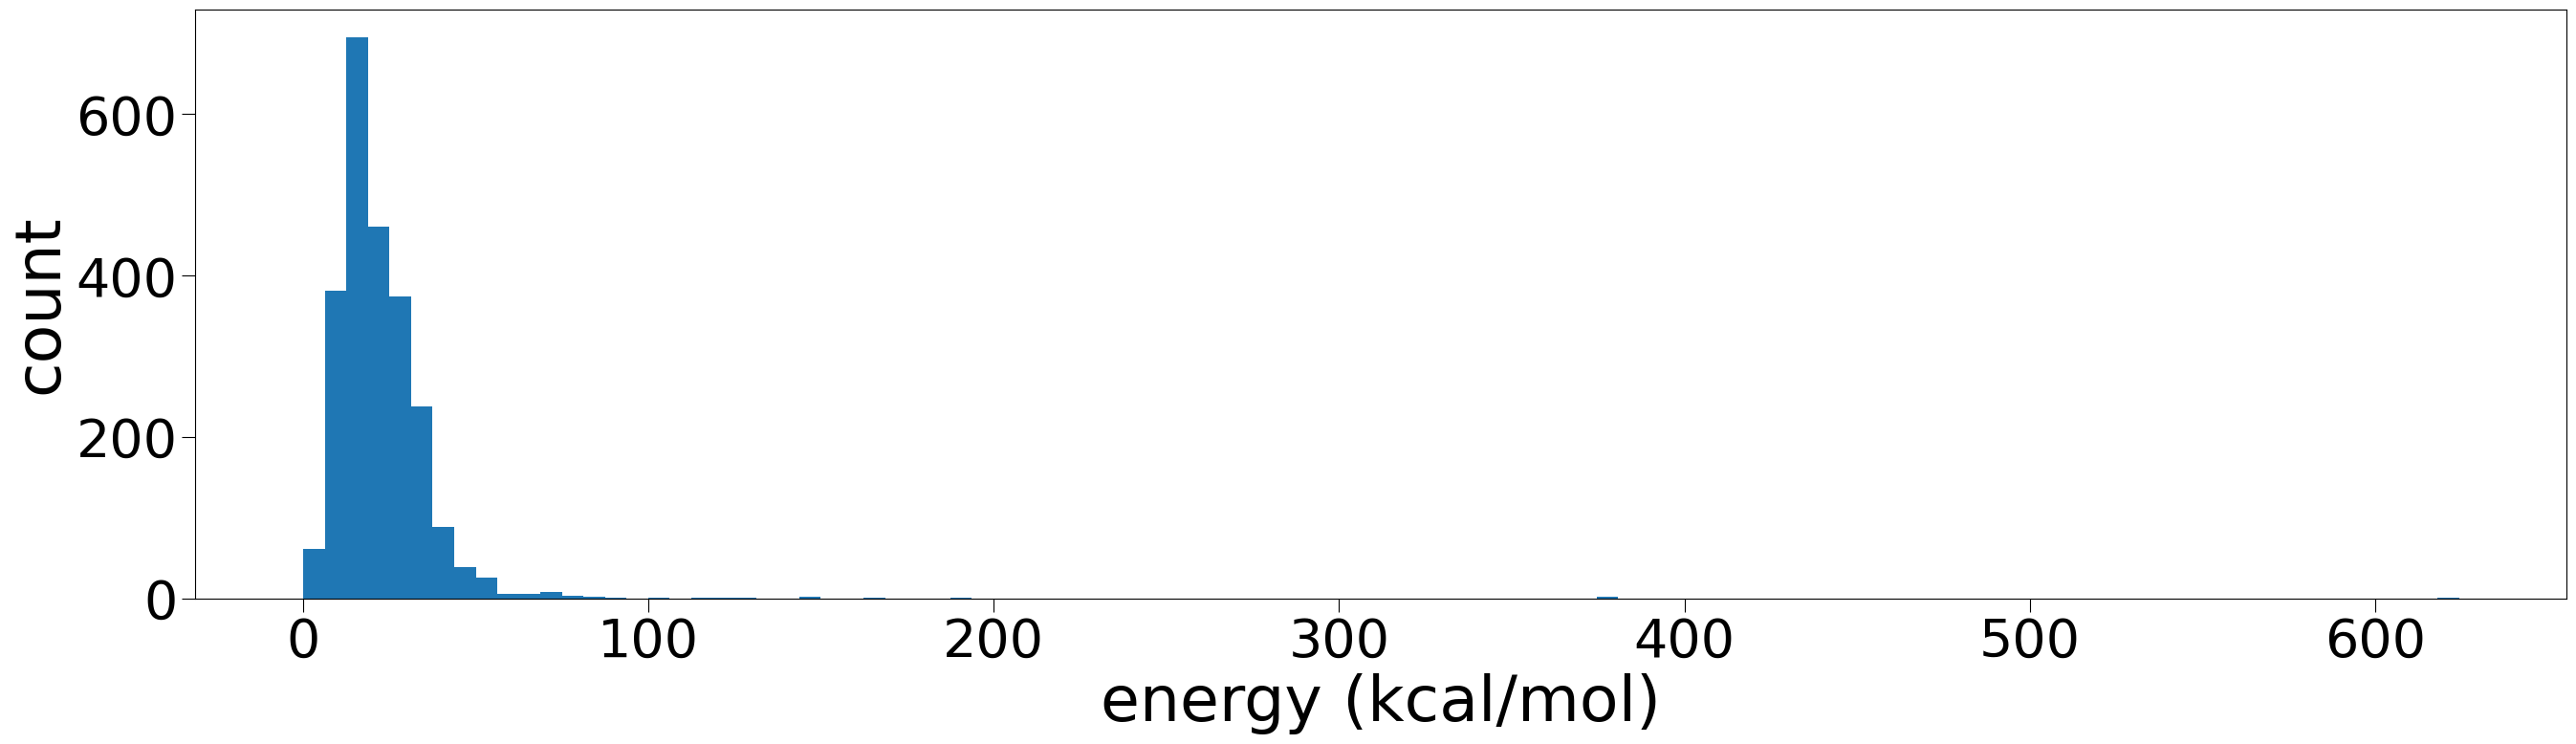

In [24]:
# check energy distribution

e = np.array(energies)  # unit: kcal/mol
emax = e.max()
emin = e.min()
print('total # of conformers: ', len(e))
print('maximum energy: ', emax)
print('minimum energy: ', emin)
print(f'# conformers with relative energy >{energy_threshold} kcal/mol: ', len(np.where(e-emin > energy_threshold)[0]))

plt.hist(e-emin, bins=100)
plt.xlabel('energy (kcal/mol)')
plt.ylabel('count')
plt.show()

#### guanosine

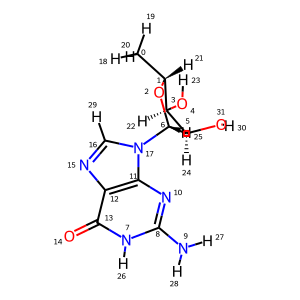

In [25]:
name = "g"
_rdmols = offmol_to_rdmol(name)
_rdmols

In [26]:
chi_atoms = [2, 6, 17, 11]
rdmols = split_rdconfs_to_rdmols(_rdmols, chi_atoms)

restraint_atoms = list(rdmols[0].GetSubstructMatch(sugar))
print(restraint_atoms)

energies = torsion_scan(rdmols[1:], chi_atoms, restraint_atoms, name, minimize=False)
energies = torsion_scan(rdmols[1:], chi_atoms, restraint_atoms, name, minimize=True)

[1, 0, 2, 6, 5, 31, 3, 4]


In [27]:
e = np.array(energies)  # unit: kcal/mol
emax = e.max()
emin = e.min()
print('total # of conformers: ', len(e))
print('maximum energy: ', emax)
print('minimum energy: ', emin)
print(f'# conformers with relative energy >{energy_threshold} kcal/mol: ', len(np.where(e-emin > energy_threshold)[0]))

total # of conformers:  2400
maximum energy:  1117.5850335921432
minimum energy:  -1.2507151817008921
# conformers with relative energy >100 kcal/mol:  14


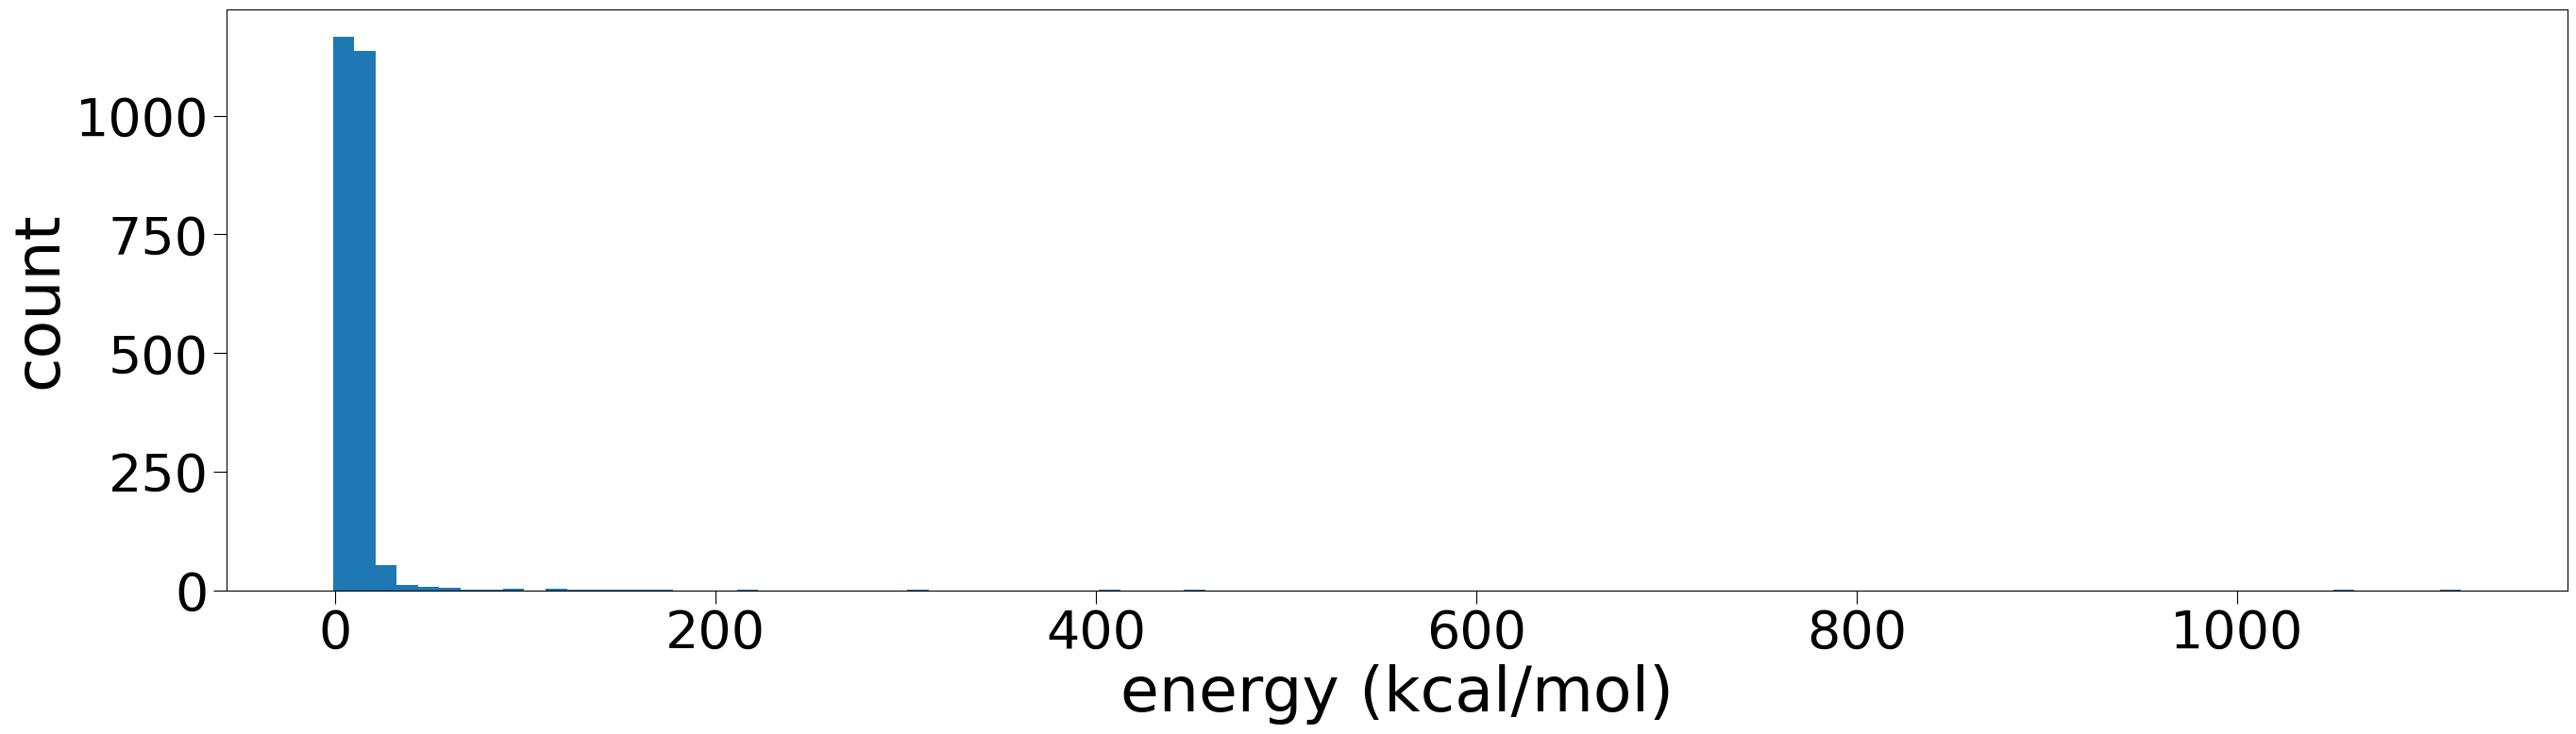

In [28]:
# check energy distribution
plt.hist(e, bins=100)
plt.xlabel('energy (kcal/mol)')
plt.ylabel('count')
plt.show()

#### uridine

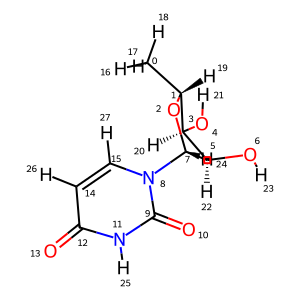

In [29]:
name = "u"
_rdmols = offmol_to_rdmol(name)
_rdmols

In [30]:
chi_atoms = [2, 7, 8, 9]
rdmols = split_rdconfs_to_rdmols(_rdmols, chi_atoms)

restraint_atoms = list(rdmols[0].GetSubstructMatch(sugar))
print(restraint_atoms)

energies = torsion_scan(rdmols[1:], chi_atoms, restraint_atoms, name, minimize=False)
energies = torsion_scan(rdmols[1:], chi_atoms, restraint_atoms, name, minimize=True)

[1, 0, 2, 7, 5, 6, 3, 4]


total # of conformers:  2400
maximum energy:  1957.7396030054256
minimum energy:  -31.629479895244934
# conformers with relative energy >100 kcal/mol:  14


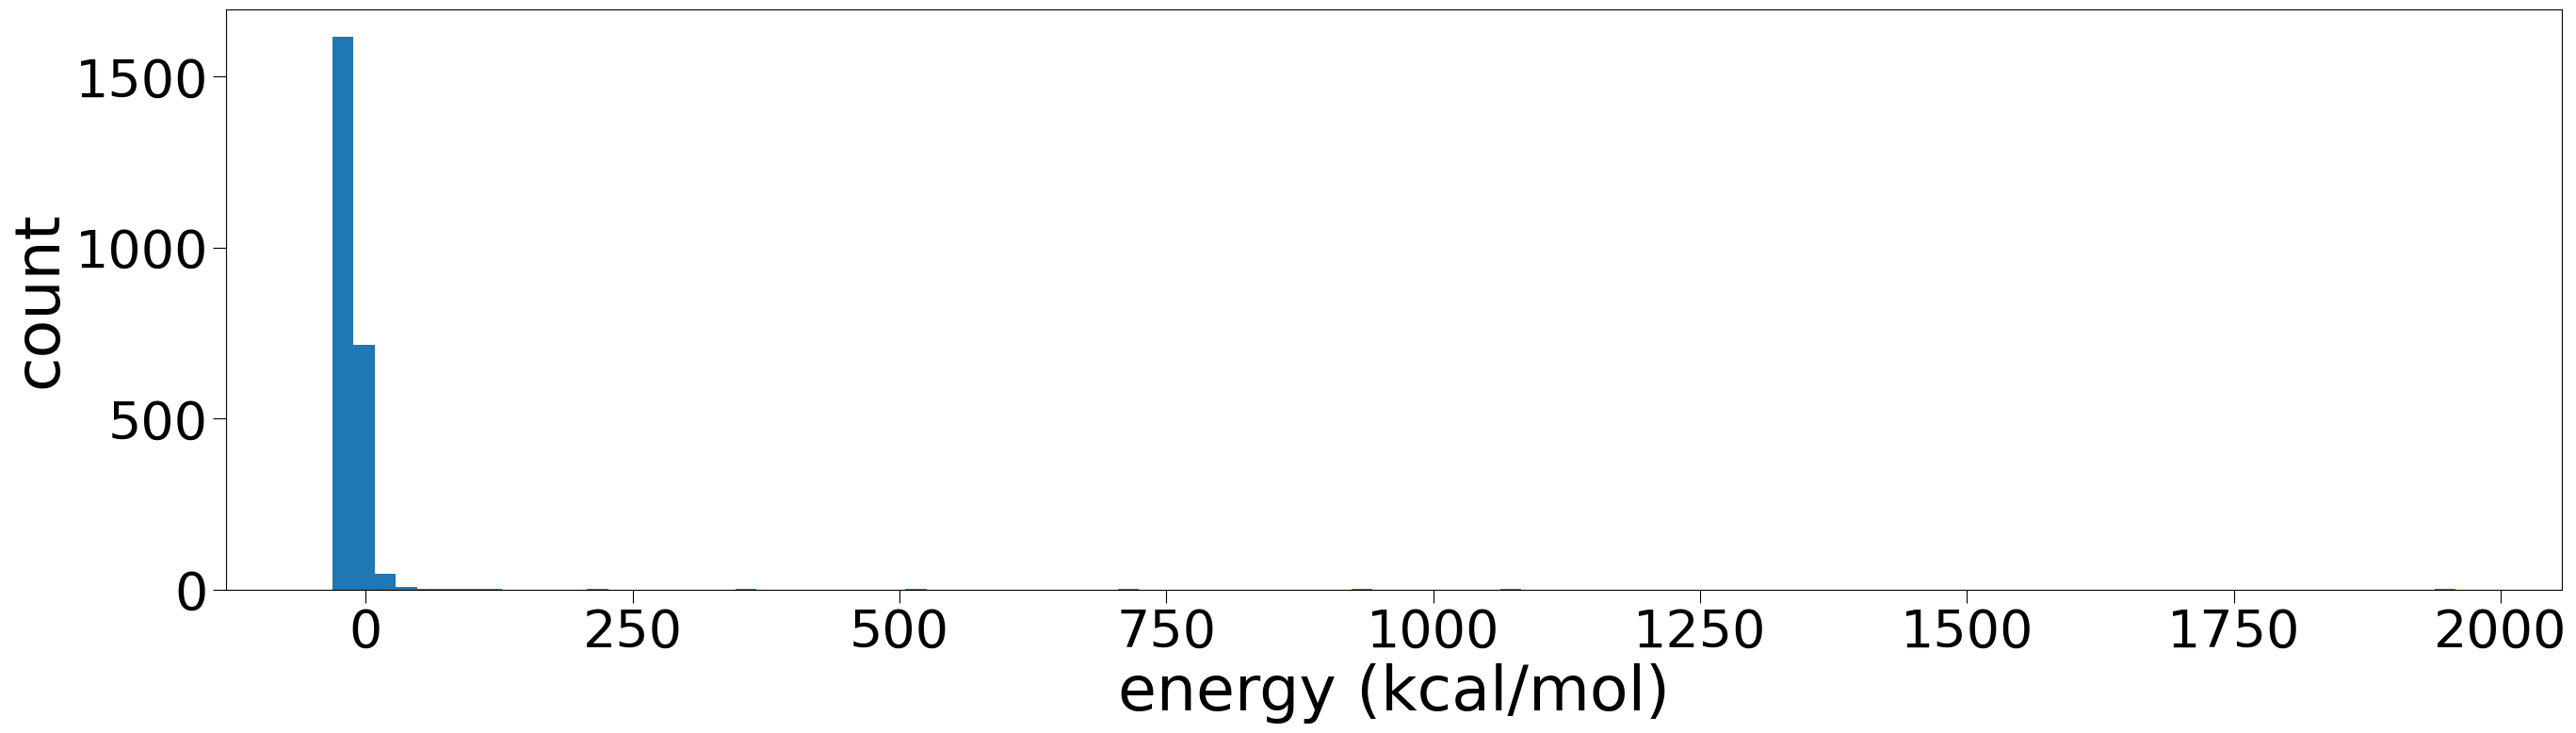

In [31]:
# check energy distribution

e = np.array(energies)  # unit: kcal/mol
emax = e.max()
emin = e.min()
print('total # of conformers: ', len(e))
print('maximum energy: ', emax)
print('minimum energy: ', emin)
print(f'# conformers with relative energy >{energy_threshold} kcal/mol: ', len(np.where(e-emin > energy_threshold)[0]))

plt.hist(e, bins=100)
plt.xlabel('energy (kcal/mol)')
plt.ylabel('count')
plt.show()